In [1]:
import os
import scipy.misc
import numpy as np
import json

from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import importlib

flags = tf.app.flags
flags.DEFINE_string("transform_type", "zoom", "The name of dataset [zoom, shiftx, shifty, rot2d]")
flags.DEFINE_boolean("steer", False, "True for traning argminGW, False for training vanilla G")
flags.DEFINE_integer("alpha_max", 5, "max of alpha for steering")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_integer("epoch", 75, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
# flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [28]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
# flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [28]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "For us this is always train mode, either true of false flag")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
FLAGS = flags.FLAGS

In [2]:
def main(_):
  pp.pprint(flags.FLAGS.__flags)

  FLAGS.train = True
   
#   if FLAGS.steer:
#     print('Training with steerable G -> loading model_argminGW2_{} ...'.format(FLAGS.transform_type))
#     DCGAN = getattr(importlib.import_module('model_argminGW2_{}'.format(FLAGS.transform_type)), 'DCGAN')
#   else:
#     print('Training vanilla G -> loading model_vanilla_{} ...'.format(FLAGS.transform_type))
#     DCGAN = getattr(importlib.import_module('model_vanilla_{}'.format(FLAGS.transform_type)), 'DCGAN')

  print('Training with steerable G for {} transformation ...'.format(FLAGS.transform_type))
  if FLAGS.transform_type == 'zoom':
    if FLAGS.steer:
      from model_argminGW2_zoom import DCGAN
    else: 
      from model_vanilla_zoom import DCGAN
        
  if FLAGS.transform_type == 'shiftx':
    if FLAGS.steer:
      from model_argminGW2_shiftx import DCGAN
    else: 
      from model_vanilla_shiftx import DCGAN
    
  if FLAGS.transform_type == 'shifty':
    if FLAGS.steer:
      from model_argminGW2_shifty import DCGAN
    else: 
      from model_vanilla_shifty import DCGAN
    
  if FLAGS.transform_type == 'rot2d':
    if FLAGS.steer:
      from model_argminGW2_rot2d import DCGAN
    else: 
      from model_vanilla_rot2d import DCGAN
    
  augment_flag_str = 'NoAug'
  if FLAGS.aug:
    augment_flag_str = 'aug'
  
  steer_flag_str = 'vanilla'
  if FLAGS.steer:
    steer_flag_str = 'argminGW'
  else:
    if FLAGS.aug:
        steer_flag_str = 'argminW'

  if FLAGS.out_name:
    FLAGS.out_name = expand_path(FLAGS.out_name)
  else:
    FLAGS.out_name = FLAGS.transform_type+'_'+augment_flag_str+'_'+steer_flag_str+\
                     '_alphamax'+str(FLAGS.alpha_max)+'_lr'+ str(FLAGS.learning_rate)
  print('Results will be saved in {}'.format(FLAGS.out_name))

  # expand user name and environment variables
  FLAGS.data_dir = expand_path(FLAGS.data_dir)
  FLAGS.out_dir = expand_path(FLAGS.out_dir)
#   FLAGS.out_name = expand_path(FLAGS.out_name)
  FLAGS.checkpoint_dir = expand_path(FLAGS.checkpoint_dir)
  FLAGS.sample_dir = expand_path(FLAGS.sample_dir)

  if FLAGS.output_height is None: FLAGS.output_height = FLAGS.input_height
  if FLAGS.input_width is None: FLAGS.input_width = FLAGS.input_height
  if FLAGS.output_width is None: FLAGS.output_width = FLAGS.output_height

  # output folders
  if FLAGS.out_name == "":
      FLAGS.out_name = '{} - {} - {}'.format(timestamp(), FLAGS.data_dir.split('/')[-1], FLAGS.dataset) # penultimate folder of path
      if FLAGS.train:
        FLAGS.out_name += ' - x{}.z{}.{}.y{}.b{}'.format(FLAGS.input_width, FLAGS.z_dim, FLAGS.z_dist, FLAGS.output_width, FLAGS.batch_size)

  FLAGS.out_dir = os.path.join(FLAGS.out_dir, FLAGS.out_name)
  FLAGS.checkpoint_dir = os.path.join(FLAGS.out_dir, FLAGS.checkpoint_dir)
  FLAGS.sample_dir = os.path.join(FLAGS.out_dir, FLAGS.sample_dir)

  if not os.path.exists(FLAGS.checkpoint_dir): os.makedirs(FLAGS.checkpoint_dir)
  if not os.path.exists(FLAGS.sample_dir): os.makedirs(FLAGS.sample_dir)

  with open(os.path.join(FLAGS.out_dir, 'FLAGS.json'), 'w') as f:
    flags_dict = {k:FLAGS[k].value for k in FLAGS}
    json.dump(flags_dict, f, indent=4, sort_keys=True, ensure_ascii=False)
  

  #gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
  run_config = tf.ConfigProto()
  run_config.gpu_options.allow_growth=True

  with tf.Session(config=run_config) as sess:
    if FLAGS.dataset == 'mnist':
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          y_dim=10,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          aug=FLAGS.aug,
          alpha_max=FLAGS.alpha_max,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)
    else:
      dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          z_dim=FLAGS.z_dim,
          dataset_name=FLAGS.dataset,
          aug=FLAGS.aug,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir,
          data_dir=FLAGS.data_dir,
          out_dir=FLAGS.out_dir,
          max_to_keep=FLAGS.max_to_keep)

    show_all_variables()

    if FLAGS.train:
      dcgan.train(FLAGS)
    else:
      load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
      if not load_success:
        raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)


    # to_json("./web/js/layers.js", [dcgan.h0_w, dcgan.h0_b, dcgan.g_bn0],
    #                 [dcgan.h1_w, dcgan.h1_b, dcgan.g_bn1],
    #                 [dcgan.h2_w, dcgan.h2_b, dcgan.g_bn2],
    #                 [dcgan.h3_w, dcgan.h3_b, dcgan.g_bn3],
    #                 [dcgan.h4_w, dcgan.h4_b, None])

    # Below is codes for visualization
      if FLAGS.export:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'export_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=True, frozen=False)

      if FLAGS.freeze:
        export_dir = os.path.join(FLAGS.checkpoint_dir, 'frozen_b'+str(FLAGS.batch_size))
        dcgan.save(export_dir, load_counter, ckpt=False, frozen=True)

      if FLAGS.visualize:
        OPTION = 1
        visualize(sess, dcgan, FLAGS, OPTION, FLAGS.sample_dir)

# if __name__ == '__main__':
#   tf.app.run()


{'G_img_sum': <absl.flags._flag.BooleanFlag object at 0x7fed94fe5eb8>,
 'alpha_max': <absl.flags._flag.Flag object at 0x7fed9cc25f60>,
 'aug': <absl.flags._flag.BooleanFlag object at 0x7fed95027f98>,
 'batch_size': <absl.flags._flag.Flag object at 0x7fed94fe5198>,
 'beta1': <absl.flags._flag.Flag object at 0x7fed94fe5048>,
 'checkpoint_dir': <absl.flags._flag.Flag object at 0x7fed94fe57f0>,
 'ckpt_freq': <absl.flags._flag.Flag object at 0x7fed94fe5be0>,
 'crop': <absl.flags._flag.BooleanFlag object at 0x7fed94fe59e8>,
 'data_dir': <absl.flags._flag.Flag object at 0x7fed94fe5630>,
 'dataset': <absl.flags._flag.Flag object at 0x7fed94fe54a8>,
 'epoch': <absl.flags._flag.Flag object at 0x7fedbc72b780>,
 'export': <absl.flags._flag.BooleanFlag object at 0x7fed94fe5ac8>,
 'freeze': <absl.flags._flag.BooleanFlag object at 0x7fed94fe5b38>,
 'h': <tensorflow.python.platform.app._HelpFlag object at 0x7fedbe74d588>,
 'help': <tensorflow.python.platform.app._HelpFlag object at 0x7fedbe74d588>,
 '

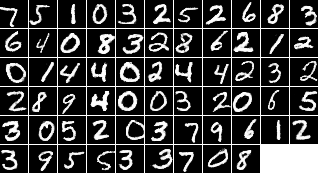

Target mask:


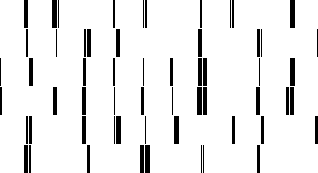

[   71800 Epoch:[ 0/100] [   0/1093] time: 6.2318, d_loss: 1.33308792, g_loss: 2.41232824, walk_loss: 2.41232824
TEST: Inside Target image:


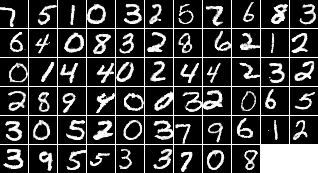

Target mask:


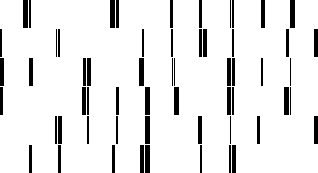

[Sample] d_loss: 1.4344565868377686, g_loss: 4.180589199066162, w_loss: 4.180589199066162
TEST: Inside Target image:


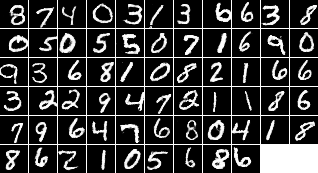

Target mask:


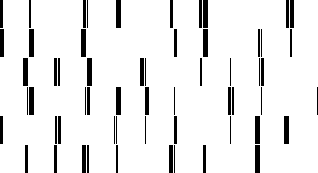

[   71801 Epoch:[ 0/100] [   1/1093] time: 10.6768, d_loss: 1.12096846, g_loss: 3.12077236, walk_loss: 3.12077236
TEST: Inside Target image:


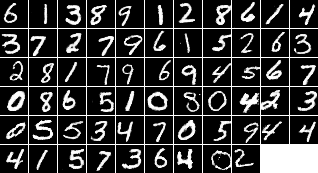

Target mask:


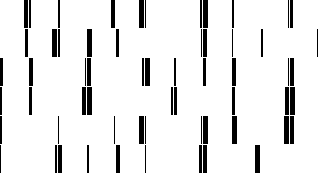

[   71802 Epoch:[ 0/100] [   2/1093] time: 10.8047, d_loss: 1.15391135, g_loss: 3.04714251, walk_loss: 3.04714227
TEST: Inside Target image:


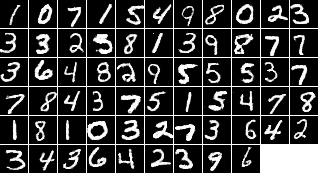

Target mask:


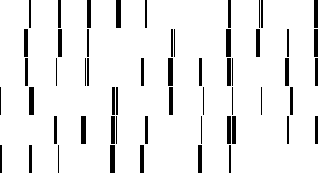

[   71803 Epoch:[ 0/100] [   3/1093] time: 10.9287, d_loss: 1.07314348, g_loss: 2.96423602, walk_loss: 2.96423554
TEST: Inside Target image:


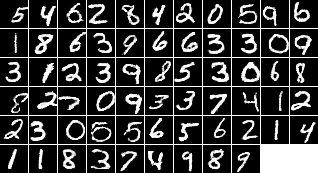

Target mask:


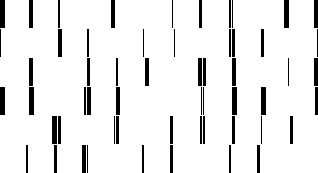

[   71804 Epoch:[ 0/100] [   4/1093] time: 11.0538, d_loss: 1.07125628, g_loss: 2.74179459, walk_loss: 2.74179411
TEST: Inside Target image:


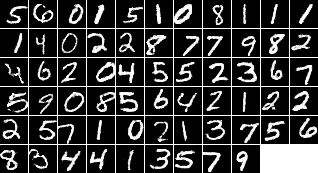

Target mask:


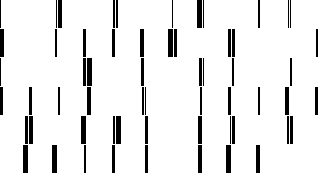

[   71805 Epoch:[ 0/100] [   5/1093] time: 11.1775, d_loss: 1.00711846, g_loss: 2.50350738, walk_loss: 2.50350714
TEST: Inside Target image:


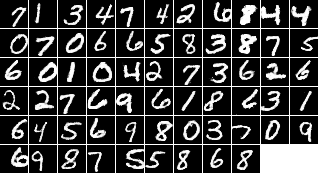

Target mask:


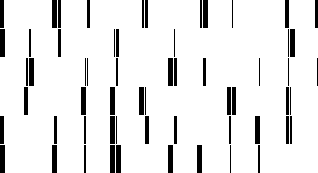

[   71806 Epoch:[ 0/100] [   6/1093] time: 11.2862, d_loss: 0.91273642, g_loss: 2.75856566, walk_loss: 2.75856566
TEST: Inside Target image:


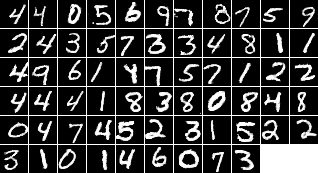

Target mask:


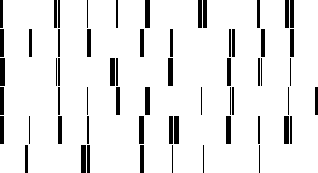

[   71807 Epoch:[ 0/100] [   7/1093] time: 11.3757, d_loss: 0.90876061, g_loss: 2.81469989, walk_loss: 2.81470013
TEST: Inside Target image:


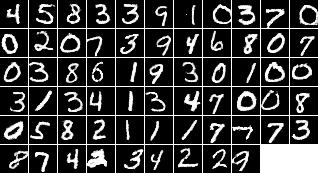

Target mask:


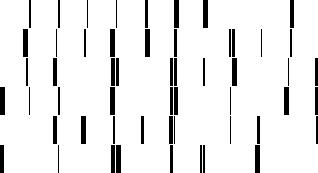

[   71808 Epoch:[ 0/100] [   8/1093] time: 11.4950, d_loss: 1.03433096, g_loss: 2.56154156, walk_loss: 2.56154180
TEST: Inside Target image:


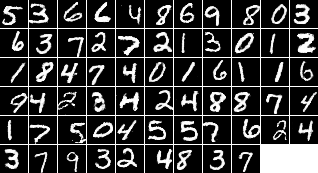

Target mask:


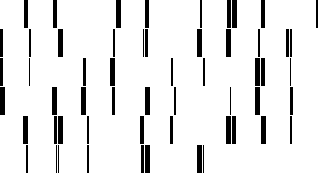

[   71809 Epoch:[ 0/100] [   9/1093] time: 11.6186, d_loss: 0.96783078, g_loss: 2.75378418, walk_loss: 2.75378418
TEST: Inside Target image:


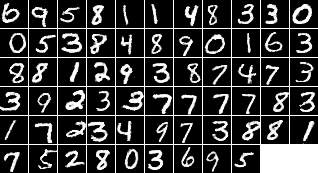

Target mask:


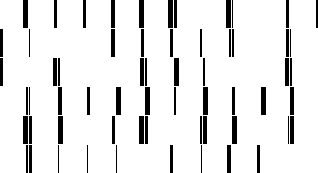

[   71810 Epoch:[ 0/100] [  10/1093] time: 11.7420, d_loss: 1.01183748, g_loss: 2.85128284, walk_loss: 2.85128307
TEST: Inside Target image:


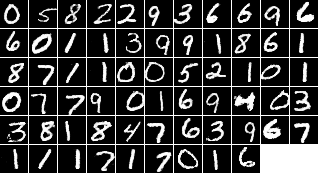

Target mask:


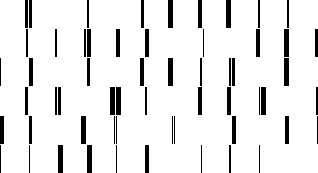

[   71811 Epoch:[ 0/100] [  11/1093] time: 11.8680, d_loss: 0.98123711, g_loss: 2.82521772, walk_loss: 2.82521796
TEST: Inside Target image:


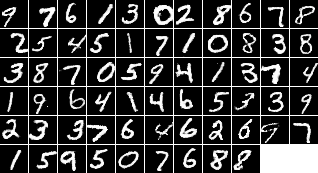

Target mask:


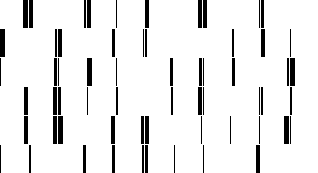

[   71812 Epoch:[ 0/100] [  12/1093] time: 12.0019, d_loss: 1.03139615, g_loss: 2.65803480, walk_loss: 2.65803480
TEST: Inside Target image:


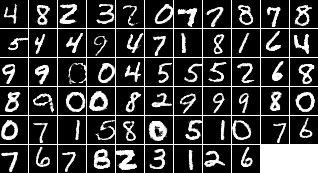

Target mask:


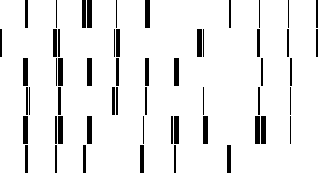

[   71813 Epoch:[ 0/100] [  13/1093] time: 12.1208, d_loss: 1.01455998, g_loss: 2.84343386, walk_loss: 2.84343386
TEST: Inside Target image:


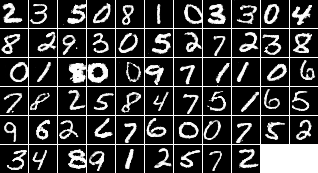

Target mask:


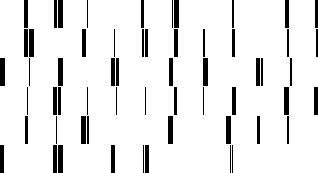

[   71814 Epoch:[ 0/100] [  14/1093] time: 12.2423, d_loss: 0.99238473, g_loss: 2.65768957, walk_loss: 2.65768957
TEST: Inside Target image:


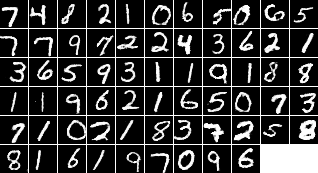

Target mask:


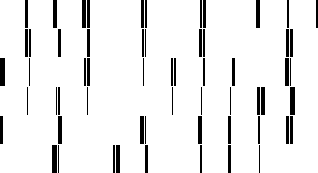

[   71815 Epoch:[ 0/100] [  15/1093] time: 12.3637, d_loss: 0.96978021, g_loss: 2.73771143, walk_loss: 2.73771167
TEST: Inside Target image:


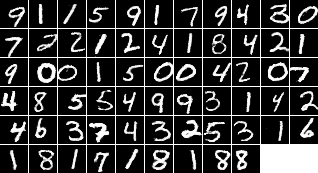

Target mask:


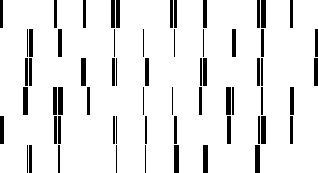

[   71816 Epoch:[ 0/100] [  16/1093] time: 12.4850, d_loss: 0.86026967, g_loss: 2.90464091, walk_loss: 2.90464067
TEST: Inside Target image:


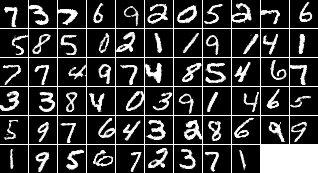

Target mask:


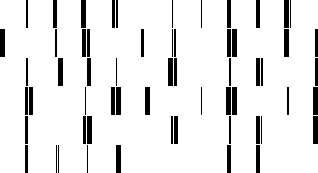

[   71817 Epoch:[ 0/100] [  17/1093] time: 12.6090, d_loss: 0.92672515, g_loss: 2.74139357, walk_loss: 2.74139404
TEST: Inside Target image:


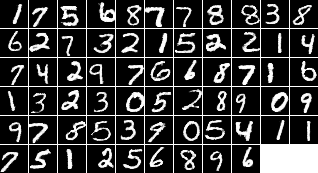

Target mask:


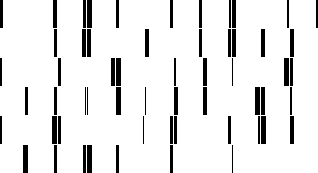

[   71818 Epoch:[ 0/100] [  18/1093] time: 12.7350, d_loss: 0.85435820, g_loss: 2.81782436, walk_loss: 2.81782484
TEST: Inside Target image:


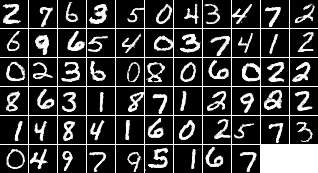

Target mask:


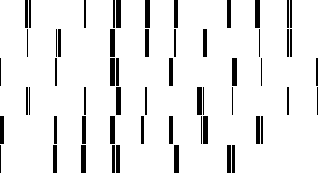

[   71819 Epoch:[ 0/100] [  19/1093] time: 12.8562, d_loss: 0.96550882, g_loss: 2.72553587, walk_loss: 2.72553539
TEST: Inside Target image:


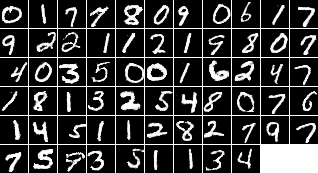

Target mask:


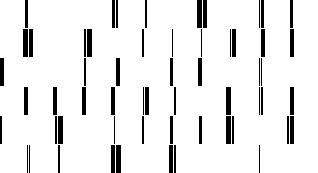

[   71820 Epoch:[ 0/100] [  20/1093] time: 12.9821, d_loss: 0.93917292, g_loss: 2.88785338, walk_loss: 2.88785315
TEST: Inside Target image:


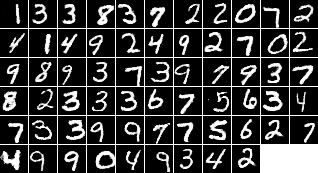

Target mask:


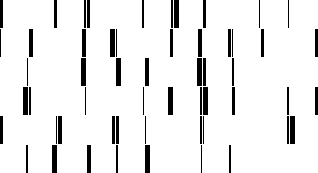

[   71821 Epoch:[ 0/100] [  21/1093] time: 13.1012, d_loss: 0.97747302, g_loss: 2.65251184, walk_loss: 2.65251207
TEST: Inside Target image:


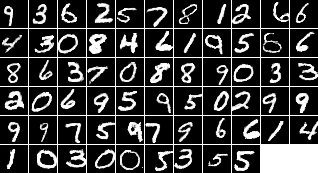

Target mask:


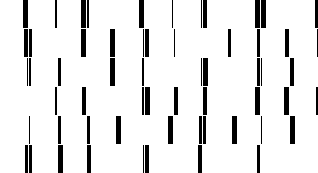

[   71822 Epoch:[ 0/100] [  22/1093] time: 13.2204, d_loss: 0.96915251, g_loss: 2.91201997, walk_loss: 2.91201949
TEST: Inside Target image:


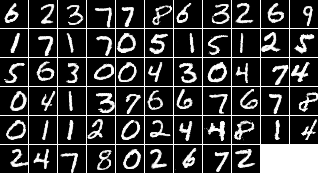

Target mask:


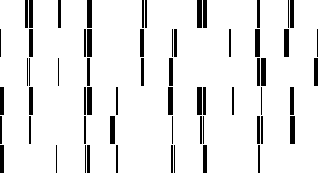

[   71823 Epoch:[ 0/100] [  23/1093] time: 13.3440, d_loss: 1.09733701, g_loss: 2.98746181, walk_loss: 2.98746157
TEST: Inside Target image:


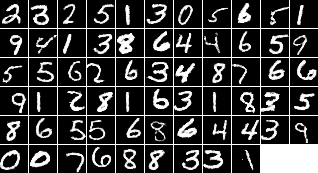

Target mask:


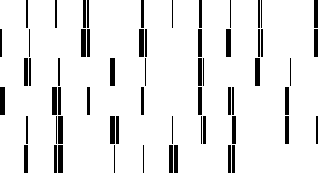

[   71824 Epoch:[ 0/100] [  24/1093] time: 13.4374, d_loss: 0.95318478, g_loss: 3.01145816, walk_loss: 3.01145840
TEST: Inside Target image:


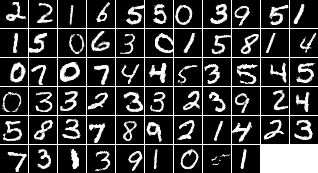

Target mask:


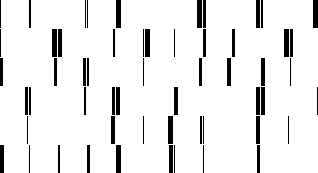

[   71825 Epoch:[ 0/100] [  25/1093] time: 13.5346, d_loss: 0.93566453, g_loss: 3.03983998, walk_loss: 3.03983998
TEST: Inside Target image:


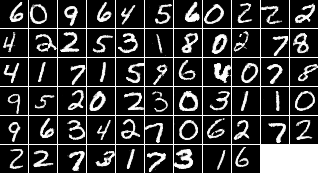

Target mask:


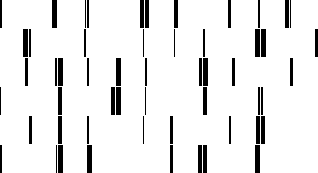

[   71826 Epoch:[ 0/100] [  26/1093] time: 13.6606, d_loss: 0.93404311, g_loss: 3.10221267, walk_loss: 3.10221219
TEST: Inside Target image:


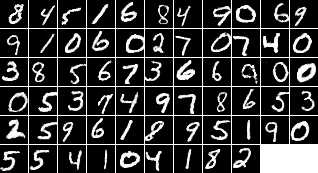

Target mask:


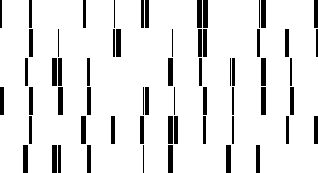

[   71827 Epoch:[ 0/100] [  27/1093] time: 13.7886, d_loss: 0.85727876, g_loss: 2.97635674, walk_loss: 2.97635674
TEST: Inside Target image:


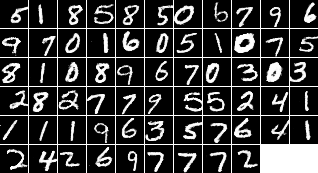

Target mask:


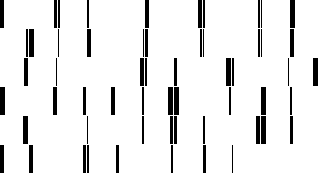

[   71828 Epoch:[ 0/100] [  28/1093] time: 13.9188, d_loss: 0.81309831, g_loss: 3.06901217, walk_loss: 3.06901240
TEST: Inside Target image:


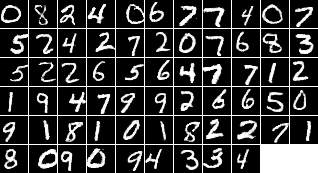

Target mask:


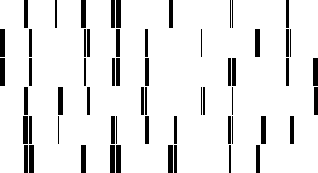

[   71829 Epoch:[ 0/100] [  29/1093] time: 14.0509, d_loss: 0.77891886, g_loss: 2.97850513, walk_loss: 2.97850561
TEST: Inside Target image:


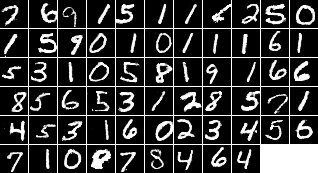

Target mask:


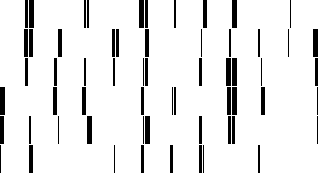

[   71830 Epoch:[ 0/100] [  30/1093] time: 14.1759, d_loss: 0.78253317, g_loss: 2.72324300, walk_loss: 2.72324324
TEST: Inside Target image:


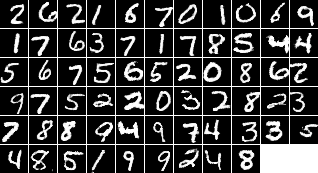

Target mask:


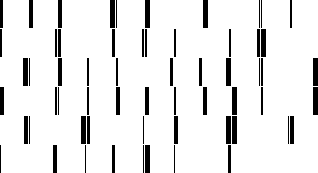

[   71831 Epoch:[ 0/100] [  31/1093] time: 14.3013, d_loss: 0.93547732, g_loss: 2.86922503, walk_loss: 2.86922550
TEST: Inside Target image:


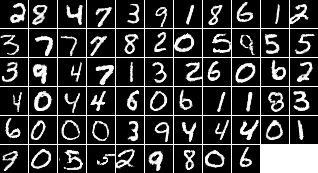

Target mask:


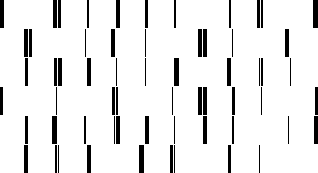

[   71832 Epoch:[ 0/100] [  32/1093] time: 14.4204, d_loss: 0.88723481, g_loss: 3.10022712, walk_loss: 3.10022783
TEST: Inside Target image:


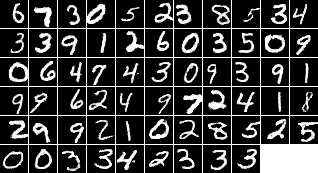

Target mask:


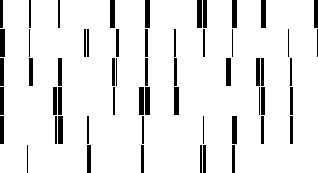

[   71833 Epoch:[ 0/100] [  33/1093] time: 14.5373, d_loss: 0.94863564, g_loss: 2.85970950, walk_loss: 2.85970950
TEST: Inside Target image:


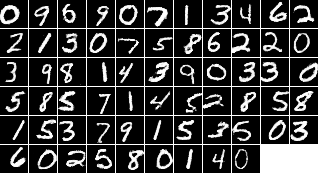

Target mask:


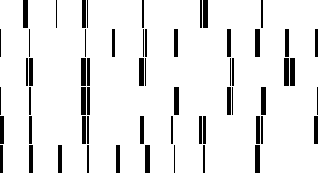

[   71834 Epoch:[ 0/100] [  34/1093] time: 14.6613, d_loss: 0.97307378, g_loss: 2.81524253, walk_loss: 2.81524277
TEST: Inside Target image:


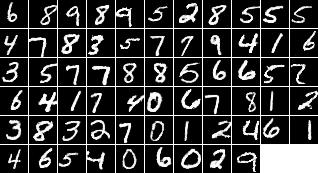

Target mask:


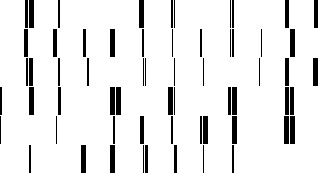

[   71835 Epoch:[ 0/100] [  35/1093] time: 14.7849, d_loss: 0.84366238, g_loss: 2.80881310, walk_loss: 2.80881286
TEST: Inside Target image:


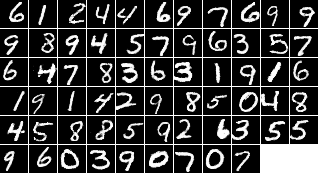

Target mask:


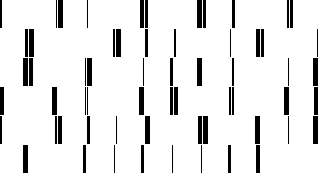

[   71836 Epoch:[ 0/100] [  36/1093] time: 14.9018, d_loss: 0.88802910, g_loss: 2.86566877, walk_loss: 2.86566901
TEST: Inside Target image:


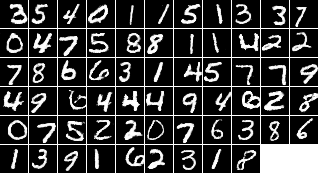

Target mask:


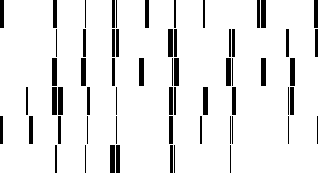

[   71837 Epoch:[ 0/100] [  37/1093] time: 15.0298, d_loss: 0.87902158, g_loss: 2.73175883, walk_loss: 2.73175931
TEST: Inside Target image:


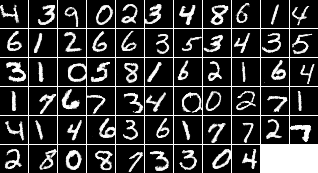

Target mask:


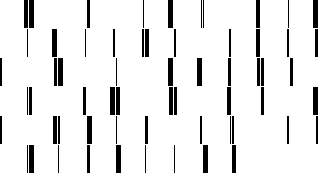

[   71838 Epoch:[ 0/100] [  38/1093] time: 15.1554, d_loss: 0.89219284, g_loss: 2.93578148, walk_loss: 2.93578148
TEST: Inside Target image:


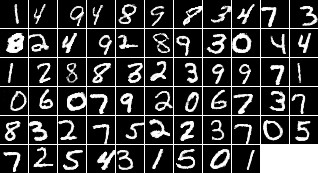

Target mask:


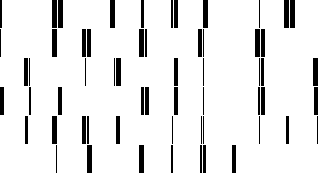

[   71839 Epoch:[ 0/100] [  39/1093] time: 15.2745, d_loss: 0.85046053, g_loss: 2.78121114, walk_loss: 2.78121138
TEST: Inside Target image:


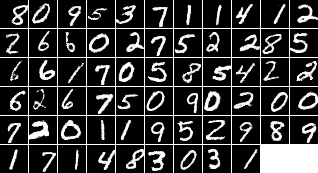

Target mask:


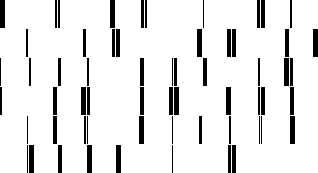

[   71840 Epoch:[ 0/100] [  40/1093] time: 15.4021, d_loss: 0.86775368, g_loss: 2.94719410, walk_loss: 2.94719410
TEST: Inside Target image:


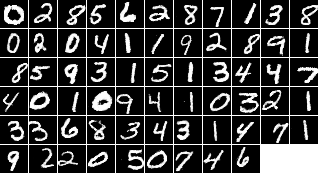

Target mask:


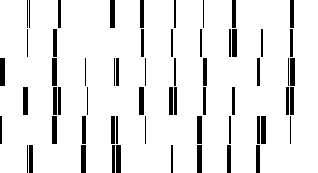

[   71841 Epoch:[ 0/100] [  41/1093] time: 15.5367, d_loss: 0.86918002, g_loss: 3.07676220, walk_loss: 3.07676196
TEST: Inside Target image:


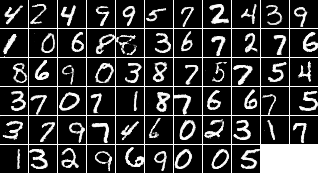

Target mask:


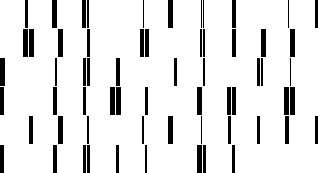

[   71842 Epoch:[ 0/100] [  42/1093] time: 15.6549, d_loss: 0.78724051, g_loss: 2.96216702, walk_loss: 2.96216655
TEST: Inside Target image:


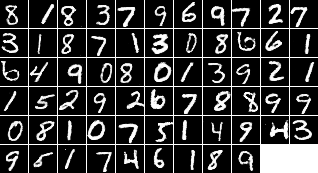

Target mask:


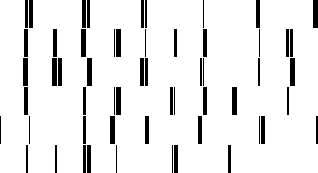

[   71843 Epoch:[ 0/100] [  43/1093] time: 15.7419, d_loss: 0.89997768, g_loss: 2.98758650, walk_loss: 2.98758626
TEST: Inside Target image:


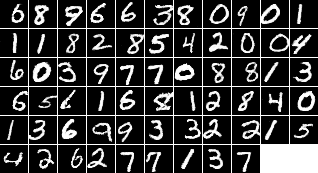

Target mask:


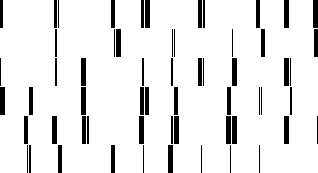

[   71844 Epoch:[ 0/100] [  44/1093] time: 15.8508, d_loss: 0.94154137, g_loss: 2.73448825, walk_loss: 2.73448825
TEST: Inside Target image:


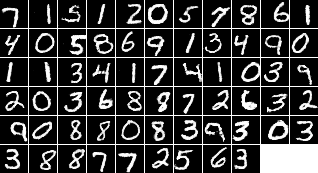

Target mask:


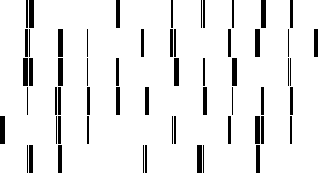

[   71845 Epoch:[ 0/100] [  45/1093] time: 15.9747, d_loss: 0.87538260, g_loss: 3.09884858, walk_loss: 3.09884858
TEST: Inside Target image:


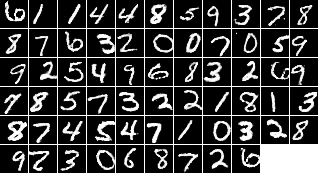

Target mask:


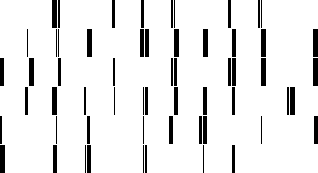

[   71846 Epoch:[ 0/100] [  46/1093] time: 16.1003, d_loss: 0.86307931, g_loss: 3.02500772, walk_loss: 3.02500796
TEST: Inside Target image:


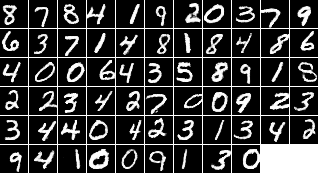

Target mask:


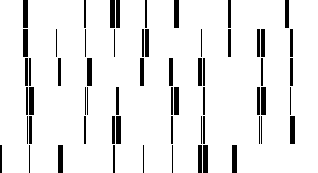

[   71847 Epoch:[ 0/100] [  47/1093] time: 16.2280, d_loss: 0.77887106, g_loss: 3.00529814, walk_loss: 3.00529766
TEST: Inside Target image:


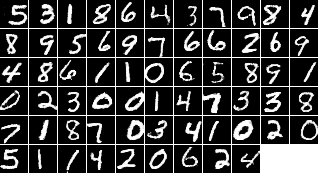

Target mask:


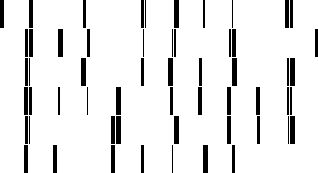

[   71848 Epoch:[ 0/100] [  48/1093] time: 16.3557, d_loss: 0.87370443, g_loss: 2.85872960, walk_loss: 2.85872936
TEST: Inside Target image:


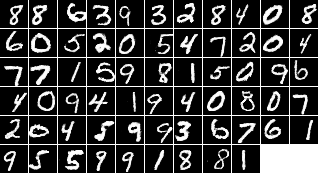

Target mask:


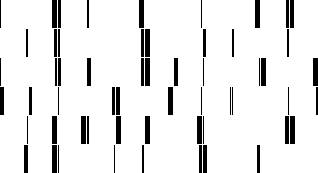

[   71849 Epoch:[ 0/100] [  49/1093] time: 16.4721, d_loss: 0.89621234, g_loss: 2.89651513, walk_loss: 2.89651537
TEST: Inside Target image:


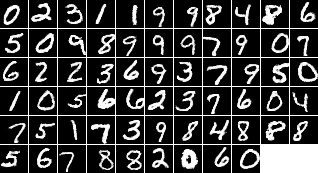

Target mask:


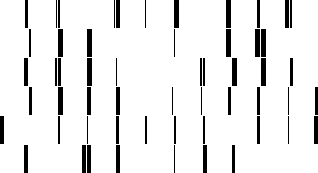

[   71850 Epoch:[ 0/100] [  50/1093] time: 16.5960, d_loss: 0.93669856, g_loss: 3.04704905, walk_loss: 3.04705000
TEST: Inside Target image:


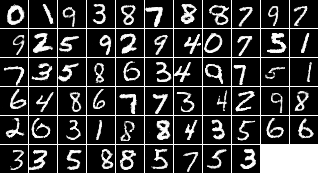

Target mask:


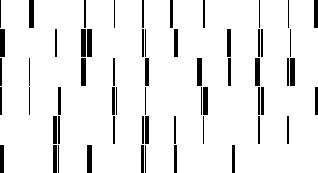

[   71851 Epoch:[ 0/100] [  51/1093] time: 16.7216, d_loss: 0.98412871, g_loss: 2.90270448, walk_loss: 2.90270448
TEST: Inside Target image:


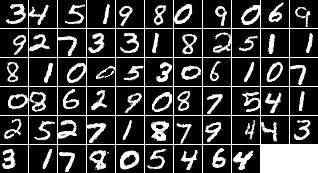

Target mask:


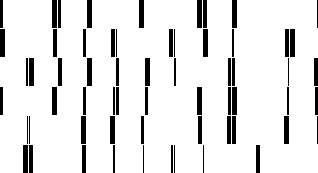

[   71852 Epoch:[ 0/100] [  52/1093] time: 16.8503, d_loss: 0.95545185, g_loss: 3.11104727, walk_loss: 3.11104727
TEST: Inside Target image:


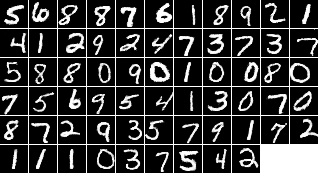

Target mask:


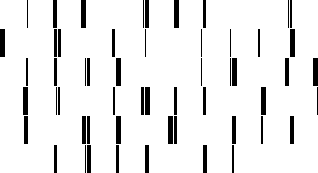

[   71853 Epoch:[ 0/100] [  53/1093] time: 16.9805, d_loss: 0.87605560, g_loss: 2.99689889, walk_loss: 2.99689770
TEST: Inside Target image:


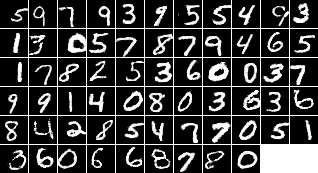

Target mask:


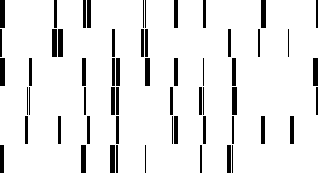

[   71854 Epoch:[ 0/100] [  54/1093] time: 17.1104, d_loss: 0.89715064, g_loss: 3.09250617, walk_loss: 3.09250617
TEST: Inside Target image:


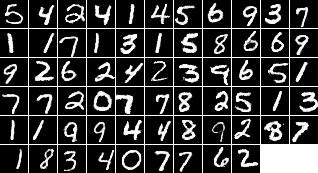

Target mask:


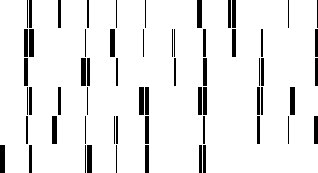

[   71855 Epoch:[ 0/100] [  55/1093] time: 17.2405, d_loss: 0.89032841, g_loss: 2.81870914, walk_loss: 2.81870961
TEST: Inside Target image:


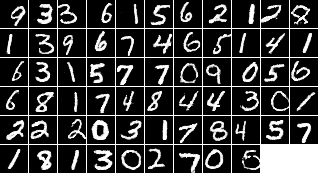

Target mask:


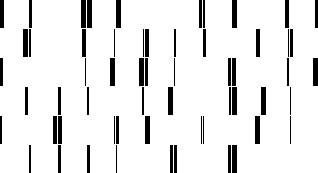

[   71856 Epoch:[ 0/100] [  56/1093] time: 17.3636, d_loss: 0.78533542, g_loss: 2.98775315, walk_loss: 2.98775363
TEST: Inside Target image:


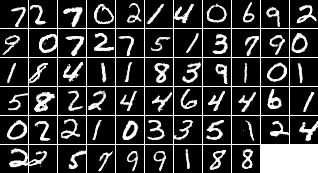

Target mask:


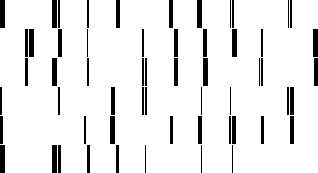

[   71857 Epoch:[ 0/100] [  57/1093] time: 17.4918, d_loss: 0.91176546, g_loss: 2.85064483, walk_loss: 2.85064507
TEST: Inside Target image:


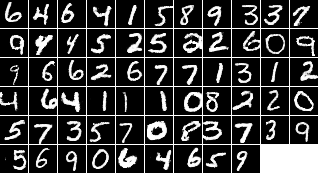

Target mask:


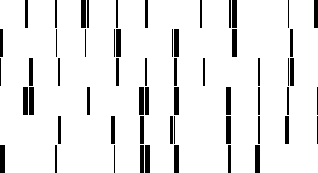

[   71858 Epoch:[ 0/100] [  58/1093] time: 17.6283, d_loss: 0.91863018, g_loss: 2.81843495, walk_loss: 2.81843472
TEST: Inside Target image:


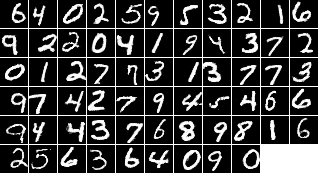

Target mask:


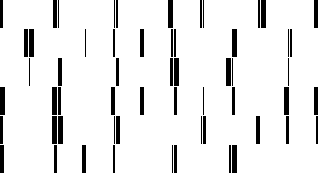

[   71859 Epoch:[ 0/100] [  59/1093] time: 17.7608, d_loss: 0.78963751, g_loss: 2.85596871, walk_loss: 2.85596824
TEST: Inside Target image:


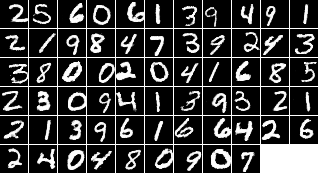

Target mask:


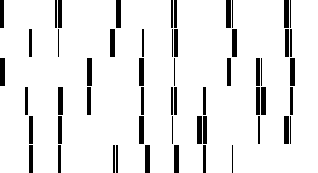

[   71860 Epoch:[ 0/100] [  60/1093] time: 17.8512, d_loss: 0.88884485, g_loss: 3.04822493, walk_loss: 3.04822516
TEST: Inside Target image:


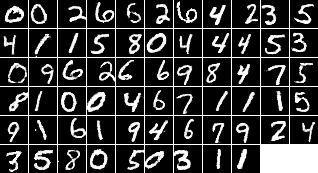

Target mask:


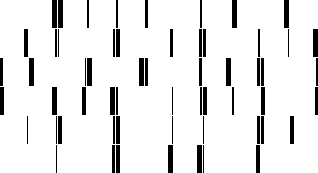

[   71861 Epoch:[ 0/100] [  61/1093] time: 17.9613, d_loss: 0.91266000, g_loss: 3.01105928, walk_loss: 3.01105952
TEST: Inside Target image:


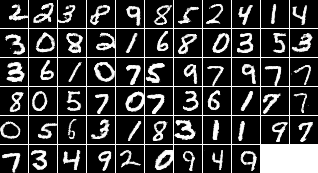

Target mask:


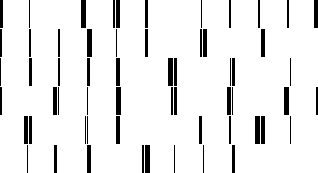

[   71862 Epoch:[ 0/100] [  62/1093] time: 18.0804, d_loss: 0.82930517, g_loss: 2.92150974, walk_loss: 2.92150998
TEST: Inside Target image:


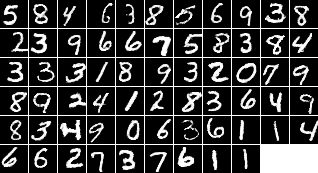

Target mask:


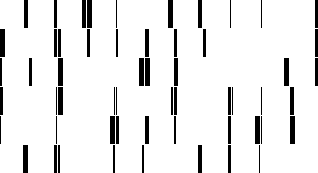

[   71863 Epoch:[ 0/100] [  63/1093] time: 18.1990, d_loss: 0.90668219, g_loss: 3.15098763, walk_loss: 3.15098715
TEST: Inside Target image:


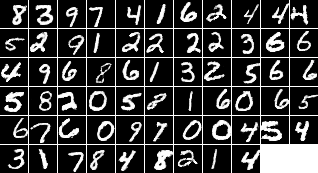

Target mask:


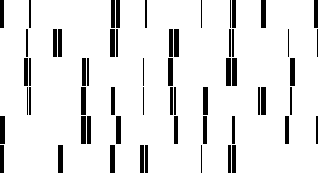

[   71864 Epoch:[ 0/100] [  64/1093] time: 18.3181, d_loss: 0.93379384, g_loss: 2.97325468, walk_loss: 2.97325492
TEST: Inside Target image:


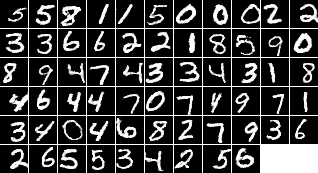

Target mask:


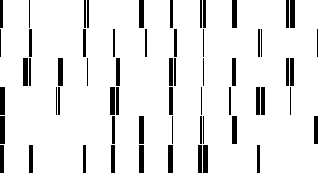

[   71865 Epoch:[ 0/100] [  65/1093] time: 18.4374, d_loss: 0.88819420, g_loss: 2.92536139, walk_loss: 2.92536139
TEST: Inside Target image:


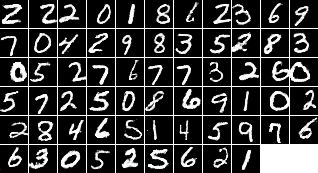

Target mask:


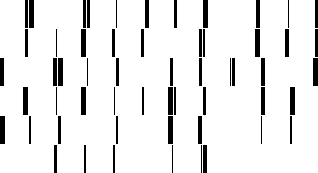

[   71866 Epoch:[ 0/100] [  66/1093] time: 18.5630, d_loss: 0.84015822, g_loss: 2.87798452, walk_loss: 2.87798500
TEST: Inside Target image:


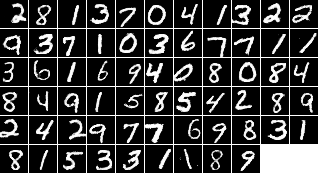

Target mask:


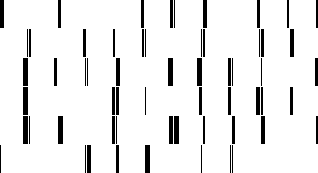

[   71867 Epoch:[ 0/100] [  67/1093] time: 18.6844, d_loss: 0.89602953, g_loss: 3.00849676, walk_loss: 3.00849676
TEST: Inside Target image:


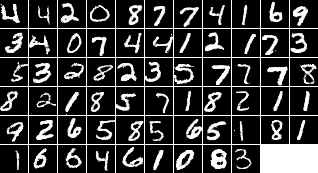

Target mask:


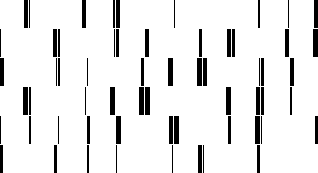

[   71868 Epoch:[ 0/100] [  68/1093] time: 18.8012, d_loss: 0.84464419, g_loss: 3.03446627, walk_loss: 3.03446627
TEST: Inside Target image:


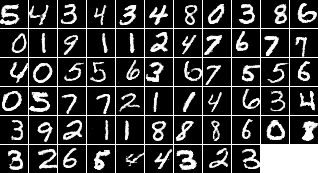

Target mask:


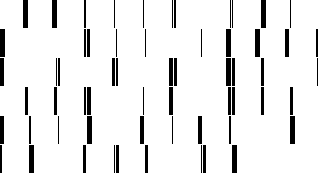

[   71869 Epoch:[ 0/100] [  69/1093] time: 18.9251, d_loss: 0.85908687, g_loss: 2.96806836, walk_loss: 2.96806836
TEST: Inside Target image:


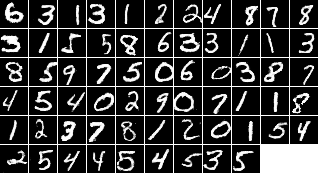

Target mask:


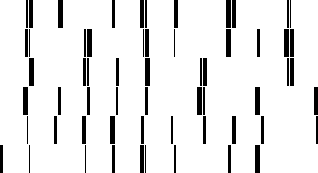

[   71870 Epoch:[ 0/100] [  70/1093] time: 19.0527, d_loss: 0.86001599, g_loss: 2.83616161, walk_loss: 2.83616161
TEST: Inside Target image:


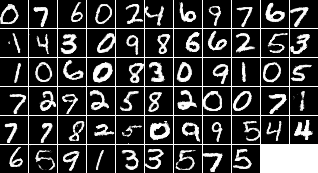

Target mask:


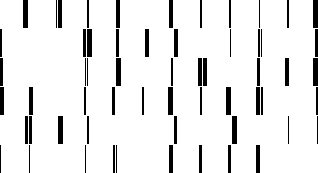

[   71871 Epoch:[ 0/100] [  71/1093] time: 19.1807, d_loss: 0.83876485, g_loss: 2.94345737, walk_loss: 2.94345808
TEST: Inside Target image:


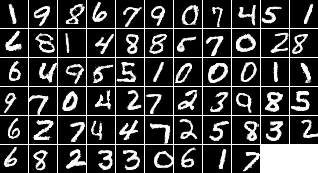

Target mask:


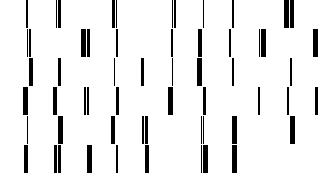

[   71872 Epoch:[ 0/100] [  72/1093] time: 19.3062, d_loss: 0.93843204, g_loss: 2.89814186, walk_loss: 2.89814138
TEST: Inside Target image:


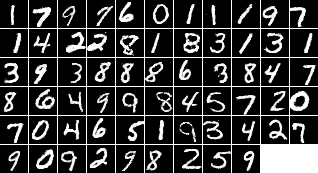

Target mask:


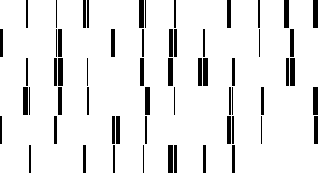

[   71873 Epoch:[ 0/100] [  73/1093] time: 19.4300, d_loss: 0.93267787, g_loss: 2.99302912, walk_loss: 2.99302936
TEST: Inside Target image:


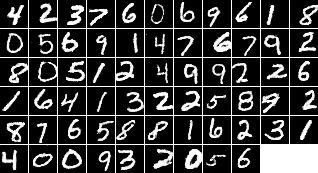

Target mask:


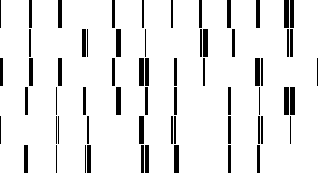

[   71874 Epoch:[ 0/100] [  74/1093] time: 19.5598, d_loss: 0.86321628, g_loss: 2.92988253, walk_loss: 2.92988276
TEST: Inside Target image:


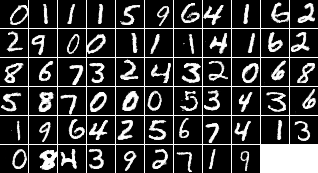

Target mask:


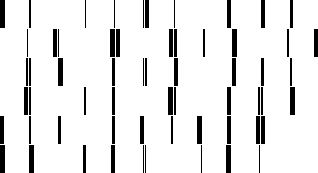

[   71875 Epoch:[ 0/100] [  75/1093] time: 19.6895, d_loss: 0.90904713, g_loss: 2.87012148, walk_loss: 2.87012148
TEST: Inside Target image:


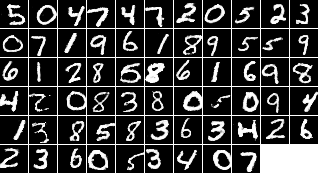

Target mask:


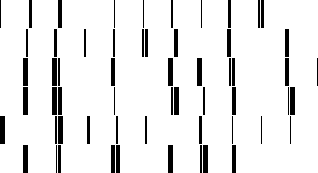

[   71876 Epoch:[ 0/100] [  76/1093] time: 19.8174, d_loss: 0.79550874, g_loss: 3.04747343, walk_loss: 3.04747391
TEST: Inside Target image:


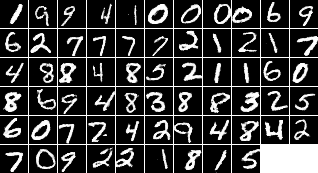

Target mask:


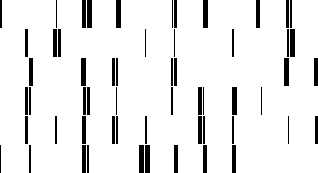

[   71877 Epoch:[ 0/100] [  77/1093] time: 19.9116, d_loss: 0.76151627, g_loss: 3.00176883, walk_loss: 3.00176907
TEST: Inside Target image:


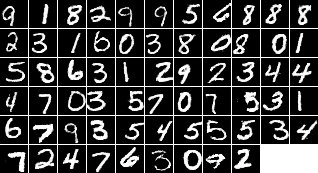

Target mask:


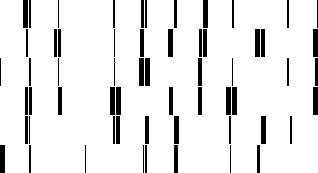

[   71878 Epoch:[ 0/100] [  78/1093] time: 20.0229, d_loss: 0.88806212, g_loss: 2.97411609, walk_loss: 2.97411609
TEST: Inside Target image:


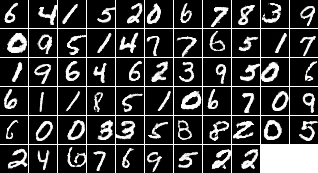

Target mask:


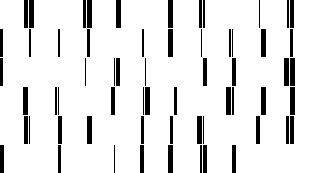

[   71879 Epoch:[ 0/100] [  79/1093] time: 20.1507, d_loss: 0.78767252, g_loss: 3.08154273, walk_loss: 3.08154321
TEST: Inside Target image:


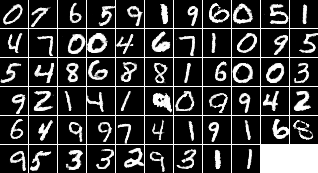

Target mask:


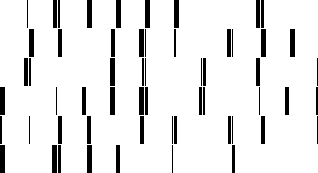

[   71880 Epoch:[ 0/100] [  80/1093] time: 20.2763, d_loss: 0.78180724, g_loss: 3.00060964, walk_loss: 3.00060916
TEST: Inside Target image:


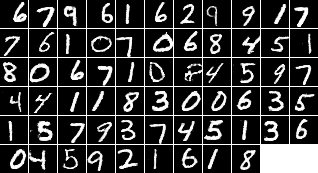

Target mask:


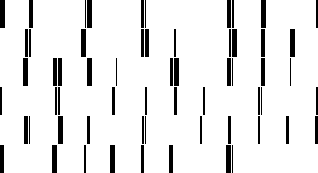

[   71881 Epoch:[ 0/100] [  81/1093] time: 20.4092, d_loss: 0.77461463, g_loss: 3.22604918, walk_loss: 3.22604895
TEST: Inside Target image:


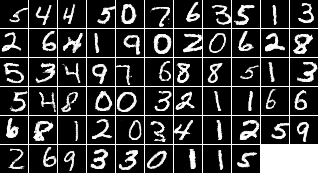

Target mask:


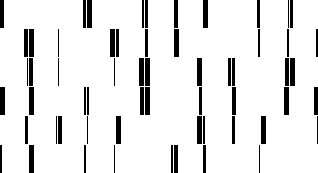

[   71882 Epoch:[ 0/100] [  82/1093] time: 20.5373, d_loss: 0.92121255, g_loss: 2.87243676, walk_loss: 2.87243676
TEST: Inside Target image:


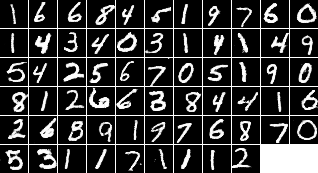

Target mask:


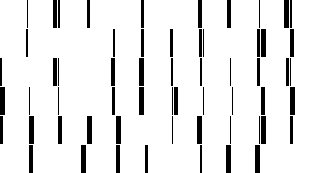

[   71883 Epoch:[ 0/100] [  83/1093] time: 20.6622, d_loss: 0.86724734, g_loss: 3.28801727, walk_loss: 3.28801727
TEST: Inside Target image:


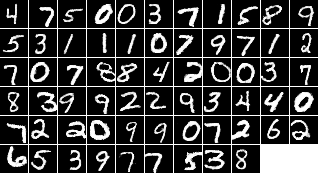

Target mask:


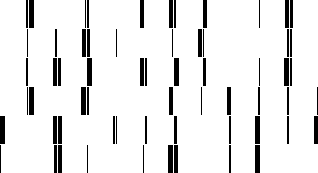

[   71884 Epoch:[ 0/100] [  84/1093] time: 20.7788, d_loss: 0.85848618, g_loss: 3.16149545, walk_loss: 3.16149497
TEST: Inside Target image:


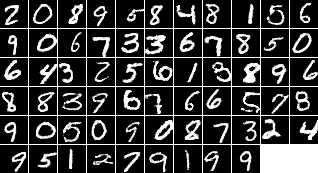

Target mask:


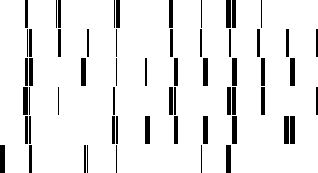

[   71885 Epoch:[ 0/100] [  85/1093] time: 20.9047, d_loss: 0.82106781, g_loss: 3.02102566, walk_loss: 3.02102566
TEST: Inside Target image:


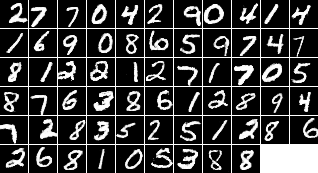

Target mask:


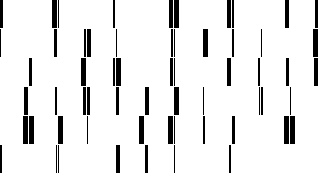

[   71886 Epoch:[ 0/100] [  86/1093] time: 21.0259, d_loss: 0.77103764, g_loss: 2.96340585, walk_loss: 2.96340585
TEST: Inside Target image:


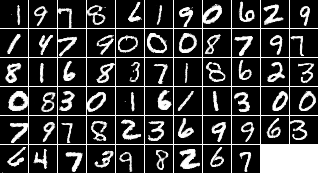

Target mask:


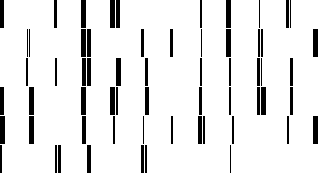

[   71887 Epoch:[ 0/100] [  87/1093] time: 21.1558, d_loss: 0.87588906, g_loss: 2.87807202, walk_loss: 2.87807178
TEST: Inside Target image:


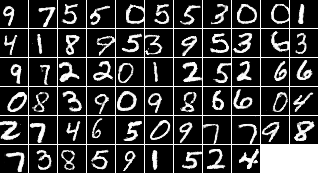

Target mask:


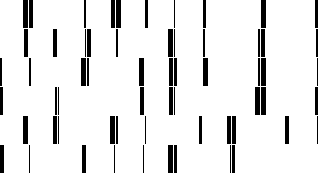

[   71888 Epoch:[ 0/100] [  88/1093] time: 21.2772, d_loss: 0.76653028, g_loss: 3.26430655, walk_loss: 3.26430726
TEST: Inside Target image:


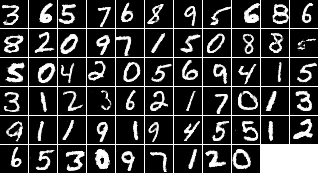

Target mask:


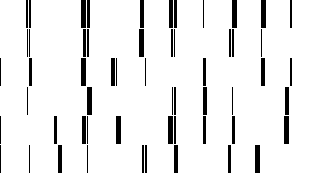

[   71889 Epoch:[ 0/100] [  89/1093] time: 21.4013, d_loss: 0.83557725, g_loss: 3.01114035, walk_loss: 3.01114035
TEST: Inside Target image:


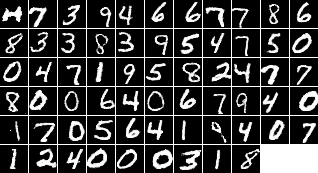

Target mask:


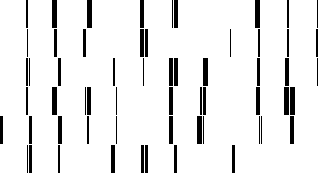

[   71890 Epoch:[ 0/100] [  90/1093] time: 21.5290, d_loss: 0.84953880, g_loss: 3.13587356, walk_loss: 3.13587356
TEST: Inside Target image:


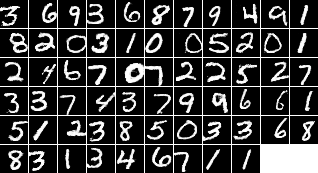

Target mask:


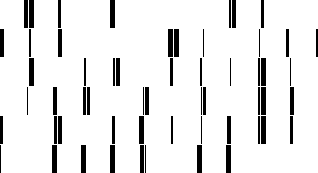

[   71891 Epoch:[ 0/100] [  91/1093] time: 21.6503, d_loss: 0.83093655, g_loss: 3.10036874, walk_loss: 3.10036850
TEST: Inside Target image:


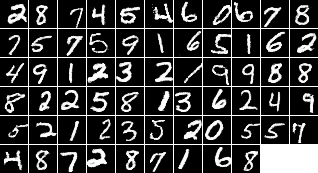

Target mask:


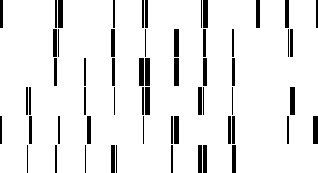

[   71892 Epoch:[ 0/100] [  92/1093] time: 21.7716, d_loss: 0.86291844, g_loss: 3.14718103, walk_loss: 3.14718103
TEST: Inside Target image:


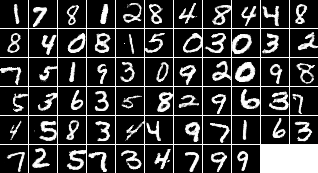

Target mask:


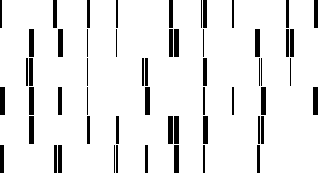

[   71893 Epoch:[ 0/100] [  93/1093] time: 21.8931, d_loss: 0.82495880, g_loss: 3.12778330, walk_loss: 3.12778234
TEST: Inside Target image:


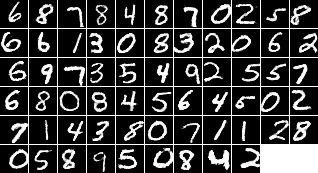

Target mask:


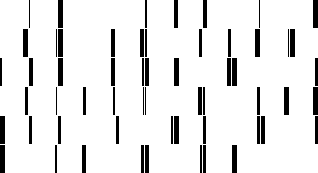

[   71894 Epoch:[ 0/100] [  94/1093] time: 21.9962, d_loss: 0.83376658, g_loss: 3.29828429, walk_loss: 3.29828429
TEST: Inside Target image:


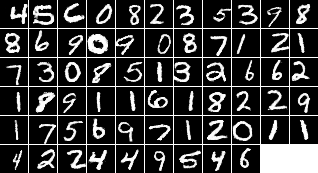

Target mask:


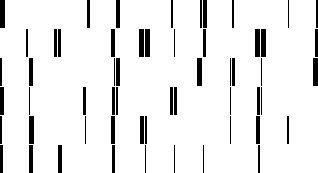

[   71895 Epoch:[ 0/100] [  95/1093] time: 22.0821, d_loss: 0.87546897, g_loss: 3.12594080, walk_loss: 3.12594080
TEST: Inside Target image:


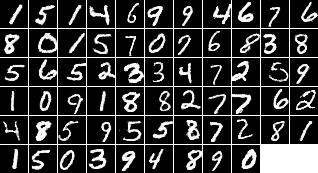

Target mask:


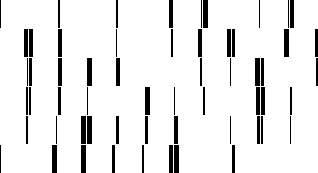

[   71896 Epoch:[ 0/100] [  96/1093] time: 22.1714, d_loss: 0.84955978, g_loss: 3.20157647, walk_loss: 3.20157647
TEST: Inside Target image:


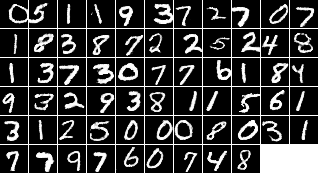

Target mask:


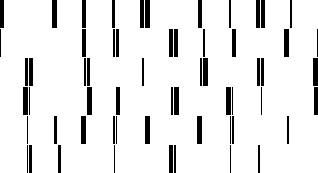

[   71897 Epoch:[ 0/100] [  97/1093] time: 22.2839, d_loss: 0.91085410, g_loss: 2.94396353, walk_loss: 2.94396400
TEST: Inside Target image:


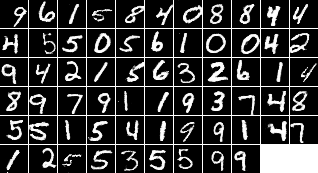

Target mask:


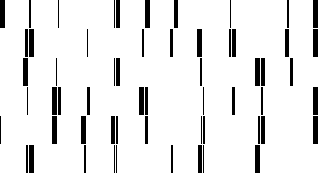

[   71898 Epoch:[ 0/100] [  98/1093] time: 22.4077, d_loss: 0.89820266, g_loss: 2.96222639, walk_loss: 2.96222615
TEST: Inside Target image:


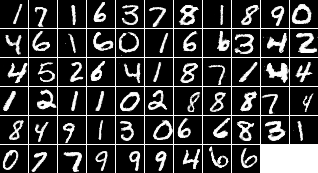

Target mask:


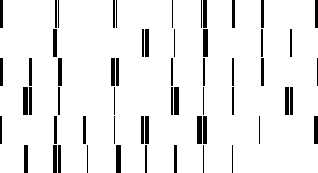

[   71899 Epoch:[ 0/100] [  99/1093] time: 22.5270, d_loss: 0.81554079, g_loss: 3.30365372, walk_loss: 3.30365300
TEST: Inside Target image:


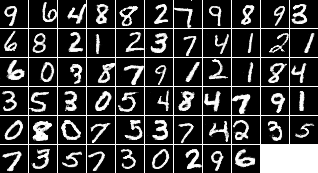

Target mask:


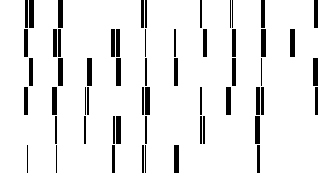

[   71900 Epoch:[ 0/100] [ 100/1093] time: 22.6509, d_loss: 0.83963215, g_loss: 2.95377731, walk_loss: 2.95377779
TEST: Inside Target image:


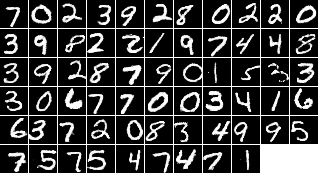

Target mask:


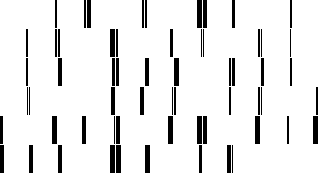

[   71901 Epoch:[ 0/100] [ 101/1093] time: 22.7719, d_loss: 0.85928810, g_loss: 3.03413415, walk_loss: 3.03413439
TEST: Inside Target image:


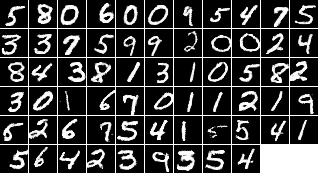

Target mask:


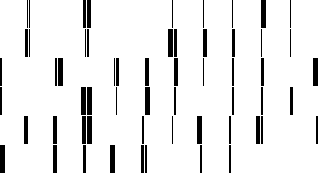

[   71902 Epoch:[ 0/100] [ 102/1093] time: 22.8957, d_loss: 0.84244043, g_loss: 2.89673185, walk_loss: 2.89673185
TEST: Inside Target image:


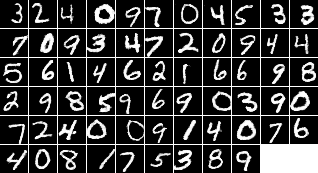

Target mask:


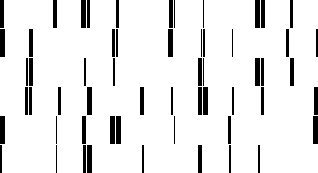

[   71903 Epoch:[ 0/100] [ 103/1093] time: 23.0239, d_loss: 0.90423822, g_loss: 2.97777271, walk_loss: 2.97777319
TEST: Inside Target image:


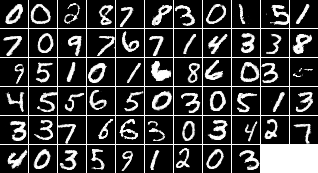

Target mask:


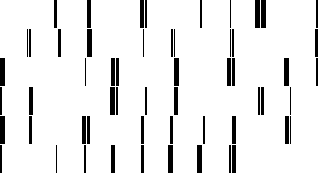

[   71904 Epoch:[ 0/100] [ 104/1093] time: 23.1470, d_loss: 0.77510059, g_loss: 3.11580682, walk_loss: 3.11580729
TEST: Inside Target image:


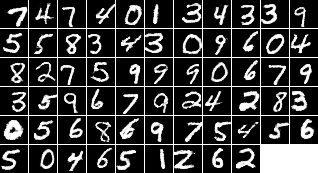

Target mask:


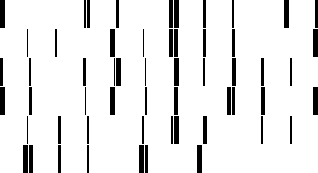

[   71905 Epoch:[ 0/100] [ 105/1093] time: 23.2681, d_loss: 0.89658421, g_loss: 3.13846016, walk_loss: 3.13846016
TEST: Inside Target image:


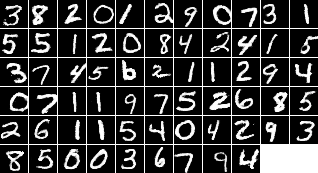

Target mask:


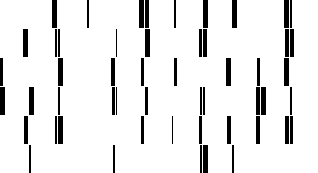

[   71906 Epoch:[ 0/100] [ 106/1093] time: 23.3913, d_loss: 0.86872000, g_loss: 3.20949459, walk_loss: 3.20949507
TEST: Inside Target image:


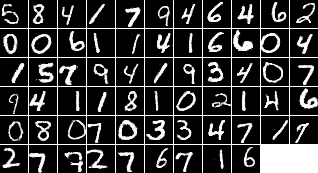

Target mask:


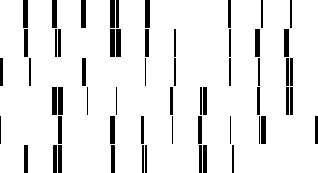

[   71907 Epoch:[ 0/100] [ 107/1093] time: 23.5214, d_loss: 0.84843194, g_loss: 2.99904871, walk_loss: 2.99904919
TEST: Inside Target image:


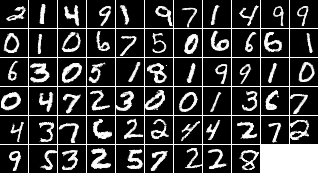

Target mask:


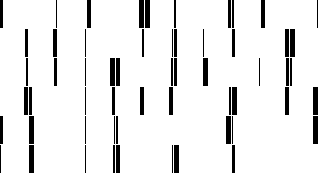

[   71908 Epoch:[ 0/100] [ 108/1093] time: 23.6445, d_loss: 0.79827464, g_loss: 3.02723026, walk_loss: 3.02723026
TEST: Inside Target image:


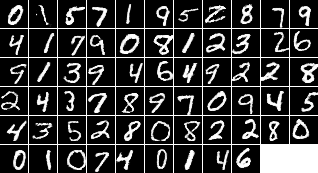

Target mask:


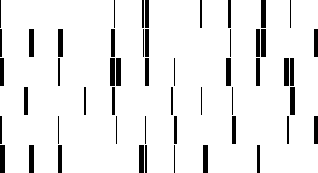

[   71909 Epoch:[ 0/100] [ 109/1093] time: 23.7636, d_loss: 0.87283063, g_loss: 2.86311603, walk_loss: 2.86311579
TEST: Inside Target image:


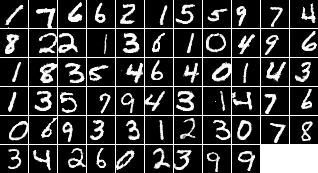

Target mask:


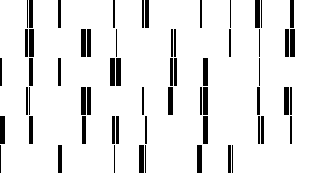

[   71910 Epoch:[ 0/100] [ 110/1093] time: 23.8917, d_loss: 0.74455208, g_loss: 3.08959794, walk_loss: 3.08959818
TEST: Inside Target image:


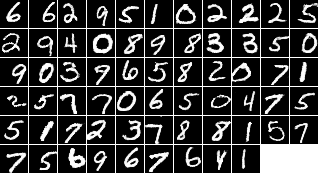

Target mask:


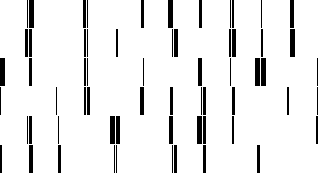

[   71911 Epoch:[ 0/100] [ 111/1093] time: 24.0238, d_loss: 0.78301239, g_loss: 3.12373710, walk_loss: 3.12373662
TEST: Inside Target image:


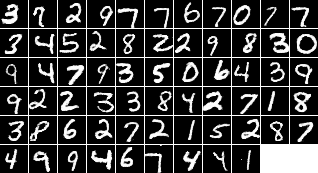

Target mask:


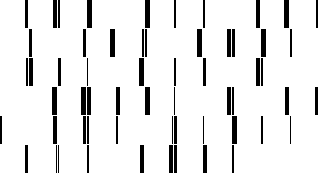

[   71912 Epoch:[ 0/100] [ 112/1093] time: 24.1427, d_loss: 0.82064617, g_loss: 2.75481534, walk_loss: 2.75481534
TEST: Inside Target image:


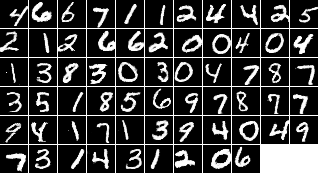

Target mask:


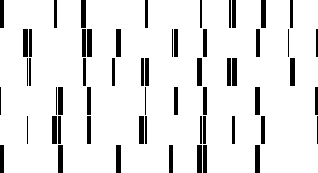

[   71913 Epoch:[ 0/100] [ 113/1093] time: 24.2347, d_loss: 0.77806938, g_loss: 3.23861599, walk_loss: 3.23861647
TEST: Inside Target image:


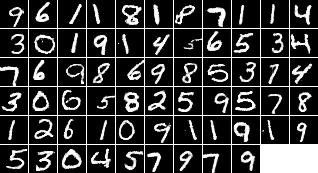

Target mask:


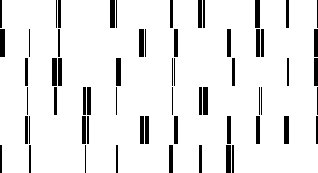

[   71914 Epoch:[ 0/100] [ 114/1093] time: 24.3429, d_loss: 0.73250687, g_loss: 3.15498567, walk_loss: 3.15498614
TEST: Inside Target image:


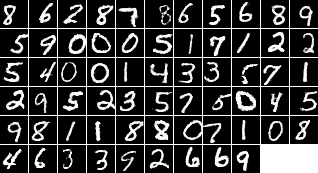

Target mask:


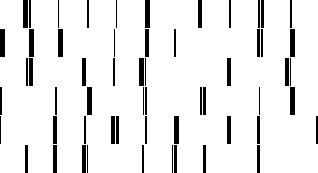

[   71915 Epoch:[ 0/100] [ 115/1093] time: 24.4686, d_loss: 0.78301102, g_loss: 3.19996405, walk_loss: 3.19996452
TEST: Inside Target image:


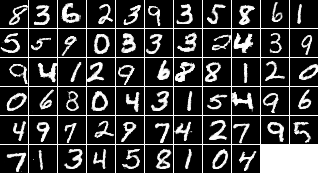

Target mask:


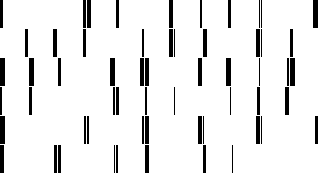

[   71916 Epoch:[ 0/100] [ 116/1093] time: 24.5900, d_loss: 0.81138527, g_loss: 2.81816792, walk_loss: 2.81816816
TEST: Inside Target image:


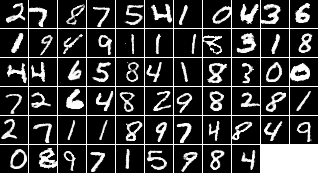

Target mask:


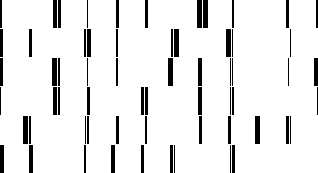

[   71917 Epoch:[ 0/100] [ 117/1093] time: 24.7138, d_loss: 0.78694350, g_loss: 3.04284787, walk_loss: 3.04284787
TEST: Inside Target image:


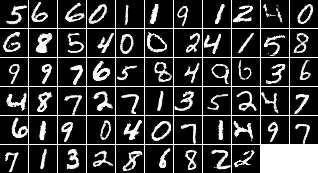

Target mask:


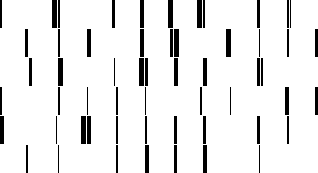

[   71918 Epoch:[ 0/100] [ 118/1093] time: 24.8348, d_loss: 0.85623276, g_loss: 3.08226347, walk_loss: 3.08226347
TEST: Inside Target image:


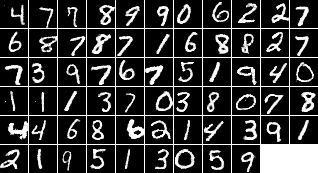

Target mask:


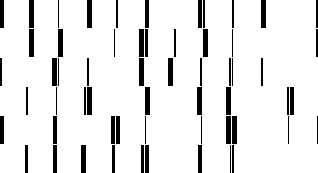

[   71919 Epoch:[ 0/100] [ 119/1093] time: 24.9564, d_loss: 0.88072824, g_loss: 2.98603129, walk_loss: 2.98603153
TEST: Inside Target image:


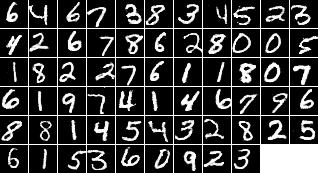

Target mask:


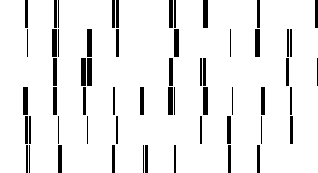

[   71920 Epoch:[ 0/100] [ 120/1093] time: 25.0885, d_loss: 0.85727000, g_loss: 2.92825413, walk_loss: 2.92825317
TEST: Inside Target image:


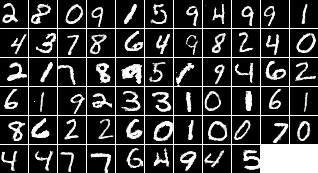

Target mask:


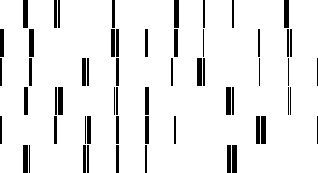

[   71921 Epoch:[ 0/100] [ 121/1093] time: 25.2144, d_loss: 0.81490487, g_loss: 3.01187873, walk_loss: 3.01187825
TEST: Inside Target image:


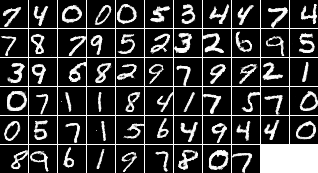

Target mask:


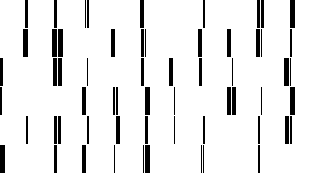

[   71922 Epoch:[ 0/100] [ 122/1093] time: 25.3397, d_loss: 0.88459563, g_loss: 2.95010567, walk_loss: 2.95010543
TEST: Inside Target image:


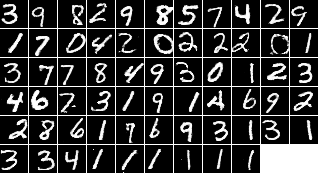

Target mask:


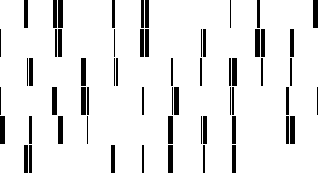

[   71923 Epoch:[ 0/100] [ 123/1093] time: 25.4609, d_loss: 0.80936223, g_loss: 3.13991213, walk_loss: 3.13991189
TEST: Inside Target image:


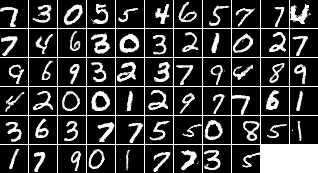

Target mask:


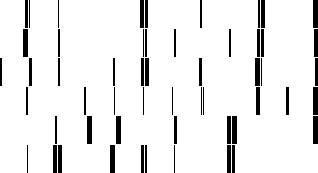

[   71924 Epoch:[ 0/100] [ 124/1093] time: 25.5822, d_loss: 0.79133672, g_loss: 2.93398786, walk_loss: 2.93398833
TEST: Inside Target image:


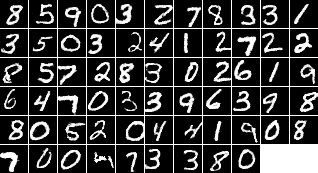

Target mask:


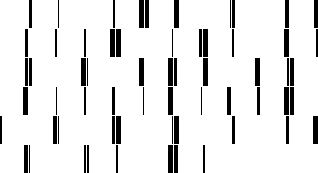

[   71925 Epoch:[ 0/100] [ 125/1093] time: 25.7125, d_loss: 0.78907752, g_loss: 2.95265603, walk_loss: 2.95265579
TEST: Inside Target image:


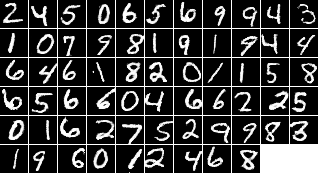

Target mask:


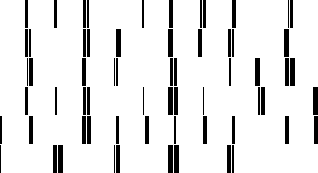

[   71926 Epoch:[ 0/100] [ 126/1093] time: 25.8380, d_loss: 0.86831611, g_loss: 2.91170192, walk_loss: 2.91170216
TEST: Inside Target image:


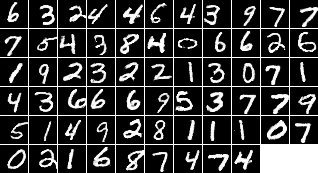

Target mask:


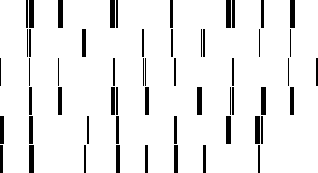

[   71927 Epoch:[ 0/100] [ 127/1093] time: 25.9549, d_loss: 0.88740098, g_loss: 2.94176531, walk_loss: 2.94176531
TEST: Inside Target image:


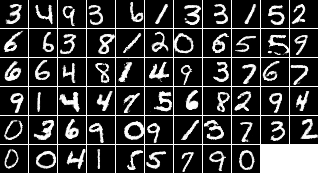

Target mask:


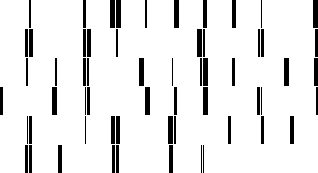

[   71928 Epoch:[ 0/100] [ 128/1093] time: 26.0742, d_loss: 0.83538568, g_loss: 3.01719213, walk_loss: 3.01719213
TEST: Inside Target image:


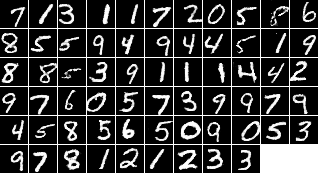

Target mask:


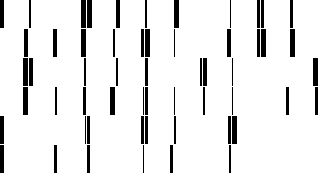

[   71929 Epoch:[ 0/100] [ 129/1093] time: 26.1931, d_loss: 0.85180712, g_loss: 3.15954113, walk_loss: 3.15954113
TEST: Inside Target image:


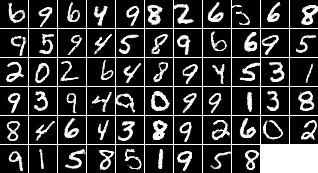

Target mask:


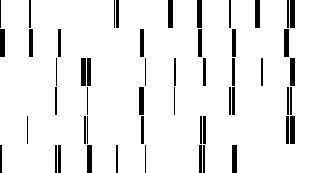

[   71930 Epoch:[ 0/100] [ 130/1093] time: 26.3166, d_loss: 0.81431848, g_loss: 3.02641153, walk_loss: 3.02641129
TEST: Inside Target image:


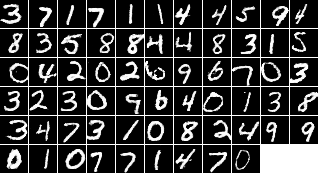

Target mask:


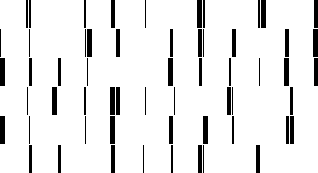

[   71931 Epoch:[ 0/100] [ 131/1093] time: 26.4136, d_loss: 0.80805075, g_loss: 3.09461141, walk_loss: 3.09461093
TEST: Inside Target image:


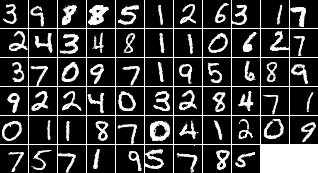

Target mask:


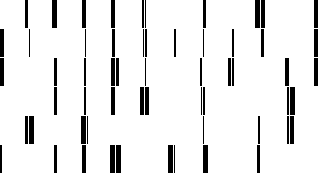

[   71932 Epoch:[ 0/100] [ 132/1093] time: 26.5126, d_loss: 0.78892702, g_loss: 3.14403605, walk_loss: 3.14403605
TEST: Inside Target image:


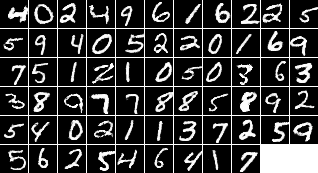

Target mask:


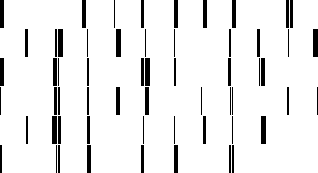

[   71933 Epoch:[ 0/100] [ 133/1093] time: 26.6323, d_loss: 0.90255868, g_loss: 2.99235010, walk_loss: 2.99235058
TEST: Inside Target image:


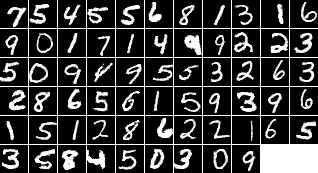

Target mask:


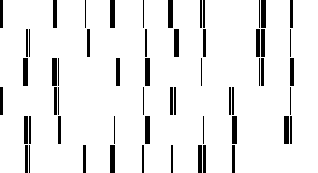

[   71934 Epoch:[ 0/100] [ 134/1093] time: 26.7583, d_loss: 0.85557008, g_loss: 3.00511122, walk_loss: 3.00511146
TEST: Inside Target image:


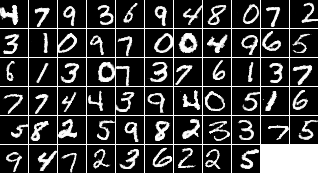

Target mask:


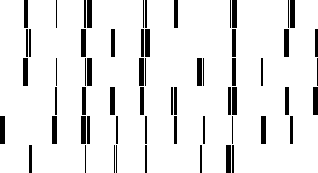

[   71935 Epoch:[ 0/100] [ 135/1093] time: 26.8841, d_loss: 0.85912538, g_loss: 3.24043512, walk_loss: 3.24043441
TEST: Inside Target image:


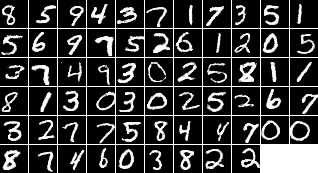

Target mask:


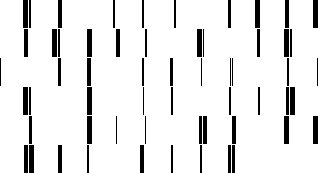

[   71936 Epoch:[ 0/100] [ 136/1093] time: 27.0076, d_loss: 0.80423629, g_loss: 3.16668224, walk_loss: 3.16668272
TEST: Inside Target image:


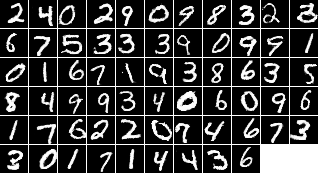

Target mask:


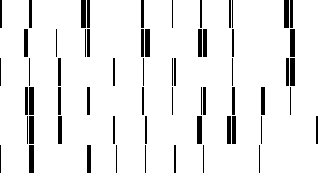

[   71937 Epoch:[ 0/100] [ 137/1093] time: 27.1242, d_loss: 0.88005900, g_loss: 3.09886622, walk_loss: 3.09886694
TEST: Inside Target image:


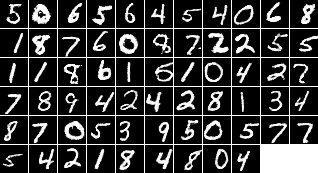

Target mask:


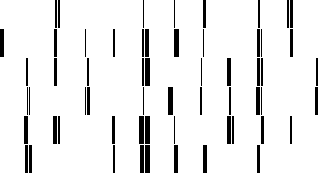

[   71938 Epoch:[ 0/100] [ 138/1093] time: 27.2541, d_loss: 0.81816864, g_loss: 3.06631255, walk_loss: 3.06631279
TEST: Inside Target image:


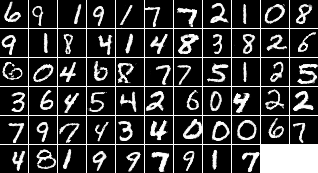

Target mask:


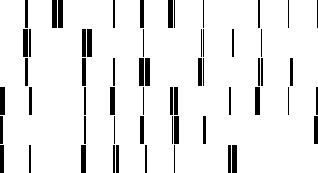

[   71939 Epoch:[ 0/100] [ 139/1093] time: 27.3777, d_loss: 0.90600514, g_loss: 3.10070682, walk_loss: 3.10070658
TEST: Inside Target image:


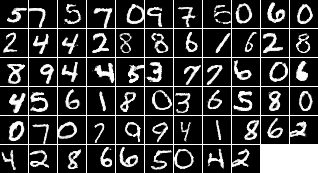

Target mask:


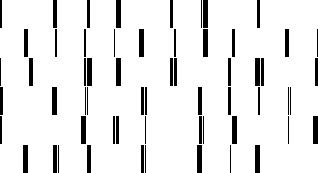

[   71940 Epoch:[ 0/100] [ 140/1093] time: 27.5028, d_loss: 0.85894656, g_loss: 3.11552119, walk_loss: 3.11552119
TEST: Inside Target image:


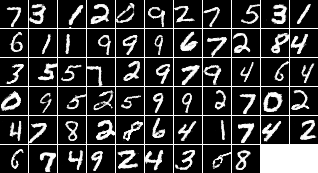

Target mask:


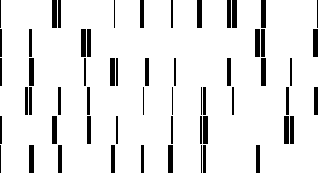

[   71941 Epoch:[ 0/100] [ 141/1093] time: 27.6197, d_loss: 0.87145644, g_loss: 3.00791311, walk_loss: 3.00791359
TEST: Inside Target image:


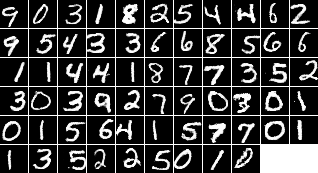

Target mask:


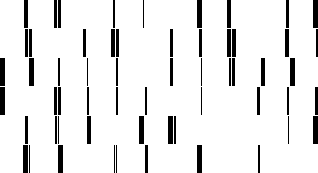

[   71942 Epoch:[ 0/100] [ 142/1093] time: 27.7449, d_loss: 0.79116219, g_loss: 3.04065061, walk_loss: 3.04065084
TEST: Inside Target image:


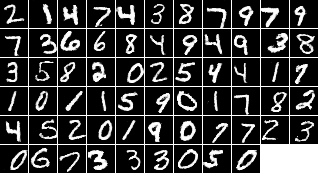

Target mask:


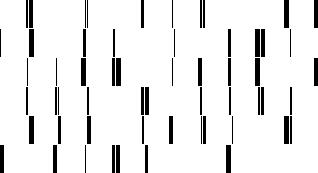

[   71943 Epoch:[ 0/100] [ 143/1093] time: 27.8728, d_loss: 0.88988727, g_loss: 2.93772721, walk_loss: 2.93772721
TEST: Inside Target image:


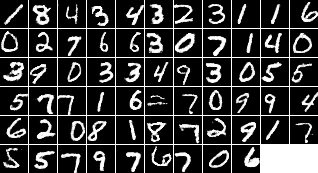

Target mask:


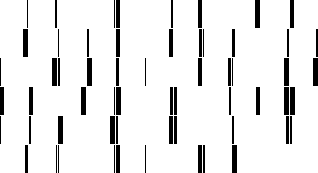

[   71944 Epoch:[ 0/100] [ 144/1093] time: 27.9921, d_loss: 0.86599672, g_loss: 3.02207303, walk_loss: 3.02207303
TEST: Inside Target image:


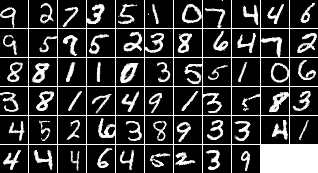

Target mask:


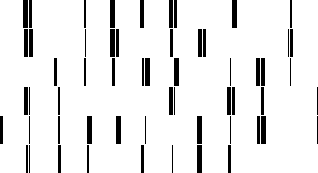

[   71945 Epoch:[ 0/100] [ 145/1093] time: 28.1132, d_loss: 0.82243794, g_loss: 2.93631053, walk_loss: 2.93631077
TEST: Inside Target image:


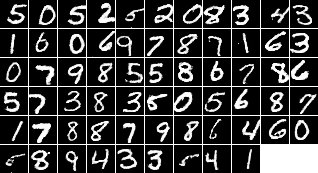

Target mask:


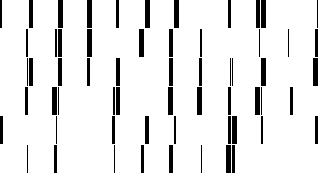

[   71946 Epoch:[ 0/100] [ 146/1093] time: 28.2387, d_loss: 0.78079623, g_loss: 3.13026667, walk_loss: 3.13026690
TEST: Inside Target image:


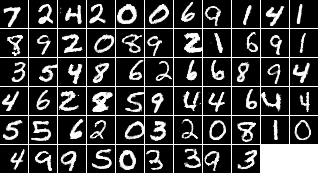

Target mask:


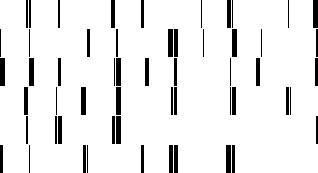

[   71947 Epoch:[ 0/100] [ 147/1093] time: 28.3573, d_loss: 0.85470760, g_loss: 3.20231175, walk_loss: 3.20231152
TEST: Inside Target image:


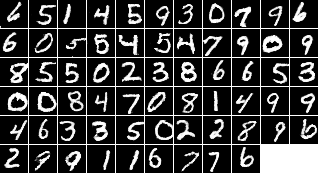

Target mask:


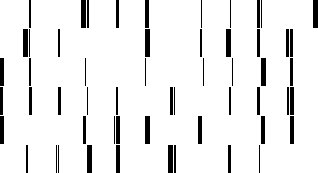

[   71948 Epoch:[ 0/100] [ 148/1093] time: 28.4849, d_loss: 0.82736421, g_loss: 3.01713991, walk_loss: 3.01713967
TEST: Inside Target image:


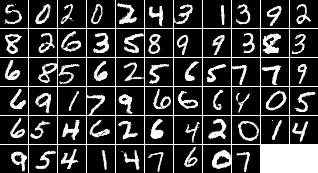

Target mask:


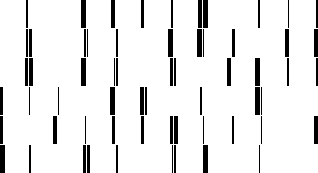

[   71949 Epoch:[ 0/100] [ 149/1093] time: 28.5778, d_loss: 0.79265273, g_loss: 3.01664972, walk_loss: 3.01664925
TEST: Inside Target image:


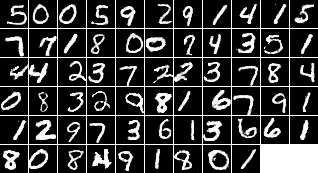

Target mask:


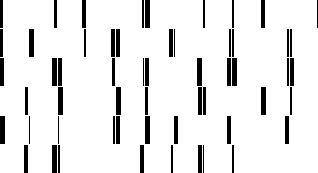

[   71950 Epoch:[ 0/100] [ 150/1093] time: 28.6795, d_loss: 0.88078618, g_loss: 3.05777287, walk_loss: 3.05777311
TEST: Inside Target image:


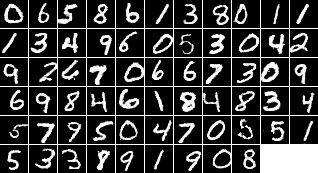

Target mask:


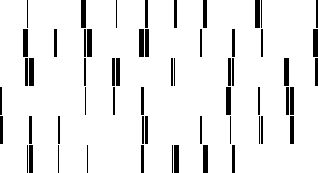

[   71951 Epoch:[ 0/100] [ 151/1093] time: 28.8070, d_loss: 0.84581524, g_loss: 2.88280487, walk_loss: 2.88280463
TEST: Inside Target image:


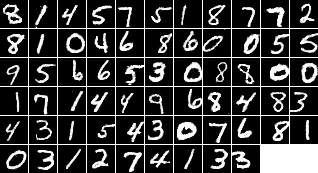

Target mask:


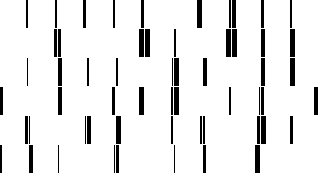

[   71952 Epoch:[ 0/100] [ 152/1093] time: 28.9300, d_loss: 0.80424023, g_loss: 2.90525937, walk_loss: 2.90525866
TEST: Inside Target image:


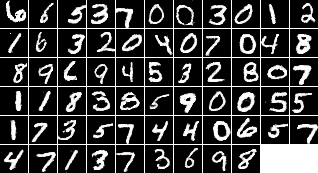

Target mask:


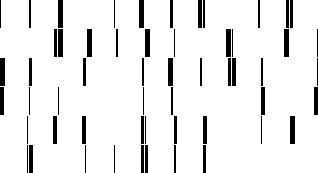

[   71953 Epoch:[ 0/100] [ 153/1093] time: 29.0557, d_loss: 0.90151572, g_loss: 3.19703984, walk_loss: 3.19703984
TEST: Inside Target image:


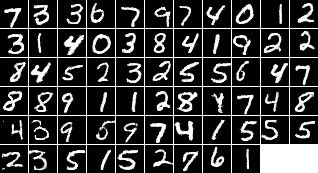

Target mask:


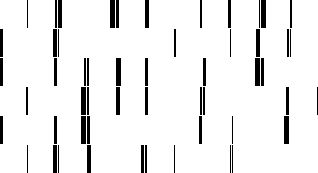

[   71954 Epoch:[ 0/100] [ 154/1093] time: 29.1837, d_loss: 0.85004199, g_loss: 3.16533542, walk_loss: 3.16533566
TEST: Inside Target image:


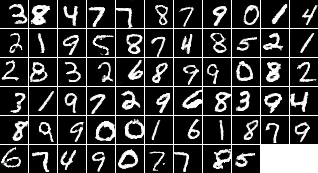

Target mask:


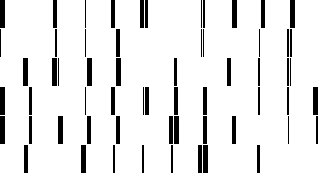

[   71955 Epoch:[ 0/100] [ 155/1093] time: 29.3048, d_loss: 0.92747390, g_loss: 3.13562775, walk_loss: 3.13562727
TEST: Inside Target image:


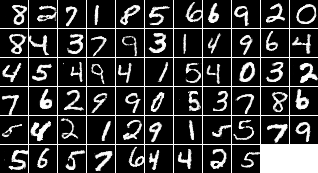

Target mask:


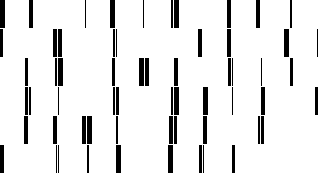

[   71956 Epoch:[ 0/100] [ 156/1093] time: 29.4304, d_loss: 0.80960977, g_loss: 3.15983987, walk_loss: 3.15983915
TEST: Inside Target image:


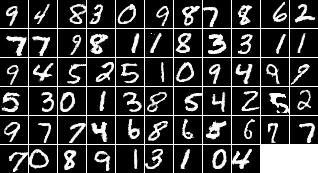

Target mask:


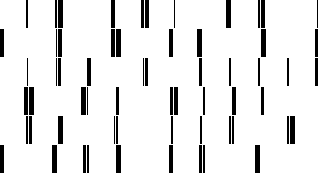

[   71957 Epoch:[ 0/100] [ 157/1093] time: 29.5497, d_loss: 0.88829756, g_loss: 2.80647969, walk_loss: 2.80647874
TEST: Inside Target image:


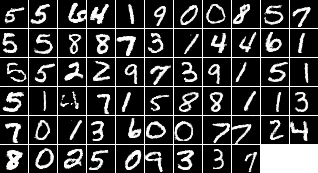

Target mask:


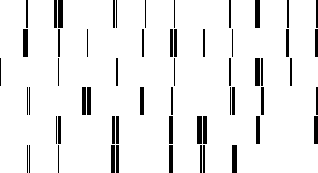

[   71958 Epoch:[ 0/100] [ 158/1093] time: 29.6694, d_loss: 0.78697324, g_loss: 3.02389169, walk_loss: 3.02389240
TEST: Inside Target image:


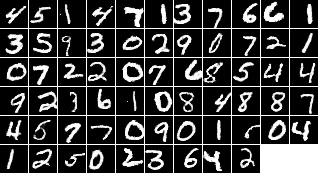

Target mask:


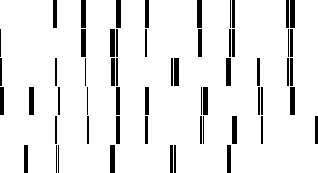

[   71959 Epoch:[ 0/100] [ 159/1093] time: 29.7775, d_loss: 0.87125385, g_loss: 3.05132890, walk_loss: 3.05132866
TEST: Inside Target image:


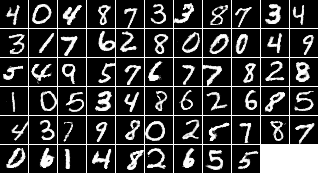

Target mask:


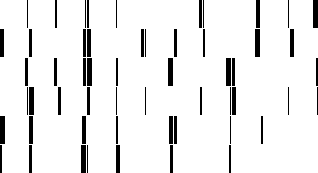

[   71960 Epoch:[ 0/100] [ 160/1093] time: 29.8900, d_loss: 0.77225399, g_loss: 3.18080115, walk_loss: 3.18080115
TEST: Inside Target image:


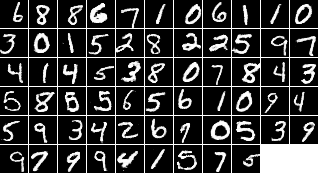

Target mask:


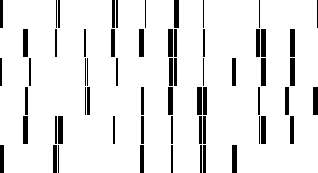

[   71961 Epoch:[ 0/100] [ 161/1093] time: 30.0025, d_loss: 0.90820003, g_loss: 2.93045044, walk_loss: 2.93045068
TEST: Inside Target image:


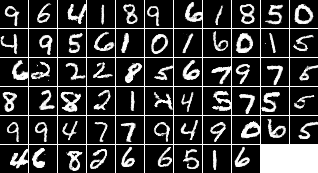

Target mask:


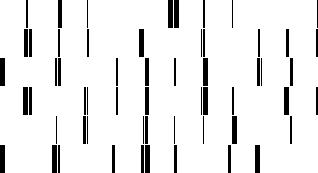

[   71962 Epoch:[ 0/100] [ 162/1093] time: 30.1238, d_loss: 0.86269140, g_loss: 3.07073426, walk_loss: 3.07073331
TEST: Inside Target image:


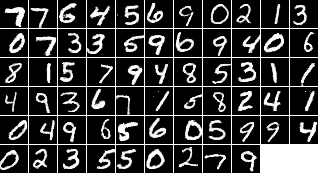

Target mask:


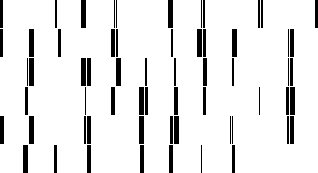

[   71963 Epoch:[ 0/100] [ 163/1093] time: 30.2366, d_loss: 0.82543683, g_loss: 3.33042765, walk_loss: 3.33042765
TEST: Inside Target image:


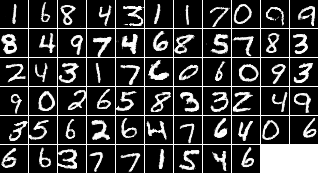

Target mask:


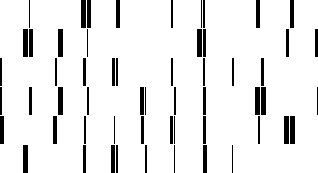

[   71964 Epoch:[ 0/100] [ 164/1093] time: 30.3534, d_loss: 0.88065922, g_loss: 3.11527228, walk_loss: 3.11527276
TEST: Inside Target image:


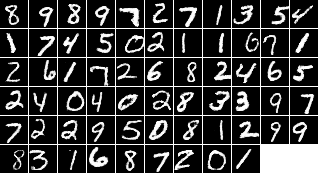

Target mask:


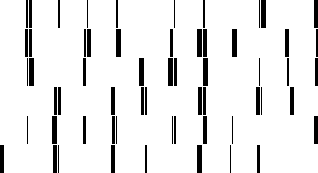

[   71965 Epoch:[ 0/100] [ 165/1093] time: 30.4707, d_loss: 0.83172035, g_loss: 3.12708712, walk_loss: 3.12708664
TEST: Inside Target image:


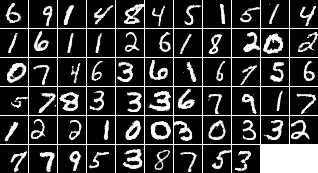

Target mask:


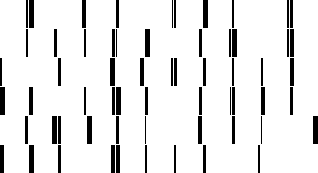

[   71966 Epoch:[ 0/100] [ 166/1093] time: 30.5923, d_loss: 0.89160180, g_loss: 2.96401763, walk_loss: 2.96401715
TEST: Inside Target image:


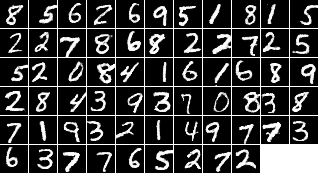

Target mask:


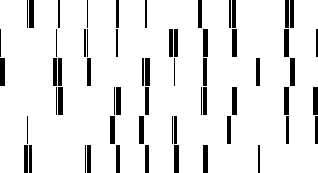

[   71967 Epoch:[ 0/100] [ 167/1093] time: 30.6853, d_loss: 0.81619567, g_loss: 3.12463188, walk_loss: 3.12463212
TEST: Inside Target image:


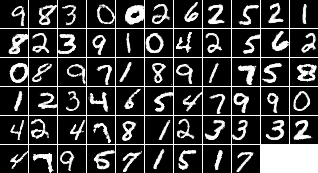

Target mask:


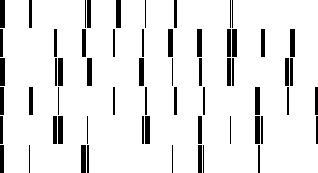

[   71968 Epoch:[ 0/100] [ 168/1093] time: 30.8048, d_loss: 0.88645864, g_loss: 3.13354611, walk_loss: 3.13354588
TEST: Inside Target image:


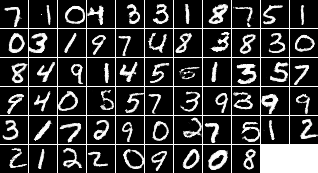

Target mask:


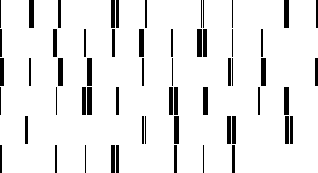

[   71969 Epoch:[ 0/100] [ 169/1093] time: 30.9325, d_loss: 0.75289321, g_loss: 3.10339832, walk_loss: 3.10339785
TEST: Inside Target image:


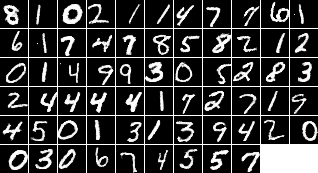

Target mask:


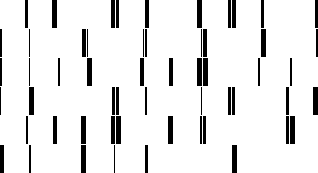

[   71970 Epoch:[ 0/100] [ 170/1093] time: 31.0561, d_loss: 0.86167741, g_loss: 3.15788460, walk_loss: 3.15788412
TEST: Inside Target image:


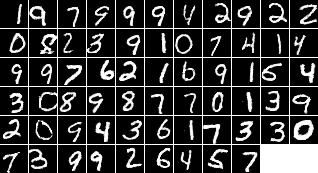

Target mask:


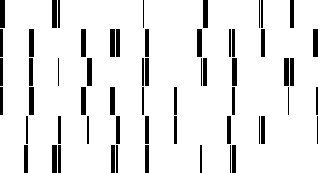

[   71971 Epoch:[ 0/100] [ 171/1093] time: 31.1747, d_loss: 0.74791074, g_loss: 3.16991377, walk_loss: 3.16991377
TEST: Inside Target image:


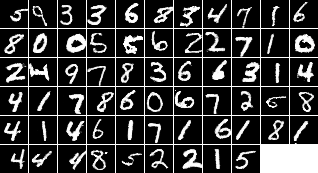

Target mask:


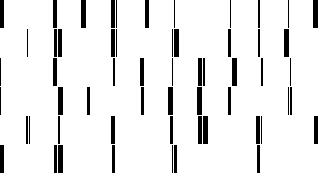

[   71972 Epoch:[ 0/100] [ 172/1093] time: 31.2936, d_loss: 0.84048688, g_loss: 2.87163162, walk_loss: 2.87163162
TEST: Inside Target image:


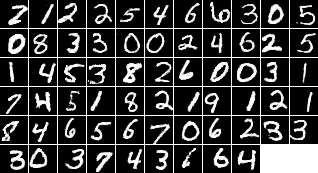

Target mask:


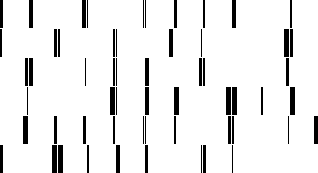

[   71973 Epoch:[ 0/100] [ 173/1093] time: 31.4170, d_loss: 0.76644450, g_loss: 3.04085732, walk_loss: 3.04085684
TEST: Inside Target image:


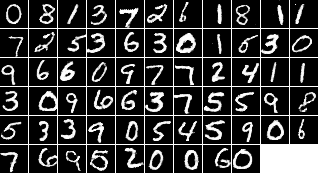

Target mask:


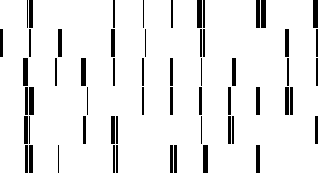

[   71974 Epoch:[ 0/100] [ 174/1093] time: 31.5403, d_loss: 0.84803671, g_loss: 3.19329262, walk_loss: 3.19329286
TEST: Inside Target image:


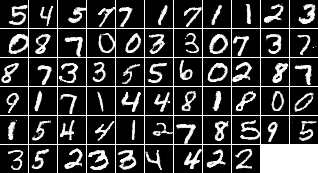

Target mask:


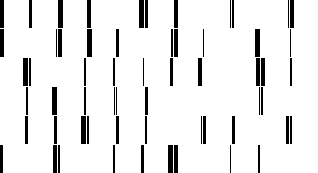

[   71975 Epoch:[ 0/100] [ 175/1093] time: 31.6687, d_loss: 0.85440350, g_loss: 3.12563014, walk_loss: 3.12563014
TEST: Inside Target image:


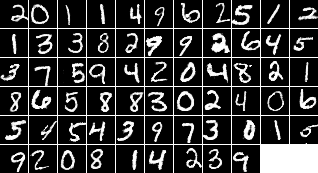

Target mask:


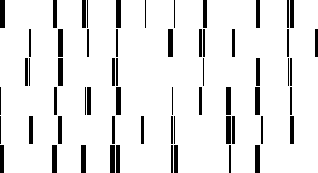

[   71976 Epoch:[ 0/100] [ 176/1093] time: 31.7947, d_loss: 0.84849548, g_loss: 3.08033562, walk_loss: 3.08033514
TEST: Inside Target image:


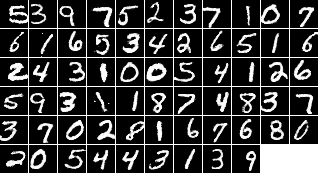

Target mask:


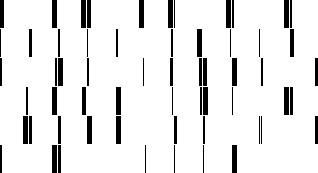

[   71977 Epoch:[ 0/100] [ 177/1093] time: 31.9167, d_loss: 0.86241657, g_loss: 3.03934598, walk_loss: 3.03934598
TEST: Inside Target image:


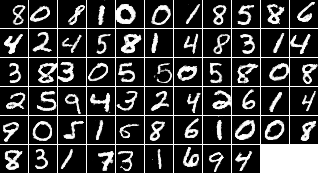

Target mask:


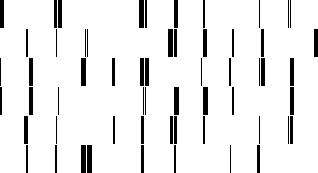

[   71978 Epoch:[ 0/100] [ 178/1093] time: 32.0391, d_loss: 0.79899961, g_loss: 3.18509293, walk_loss: 3.18509245
TEST: Inside Target image:


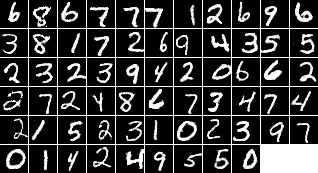

Target mask:


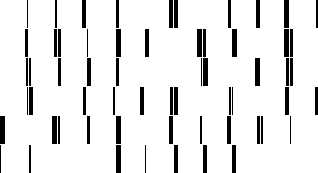

[   71979 Epoch:[ 0/100] [ 179/1093] time: 32.1652, d_loss: 0.98885959, g_loss: 2.81444740, walk_loss: 2.81444788
TEST: Inside Target image:


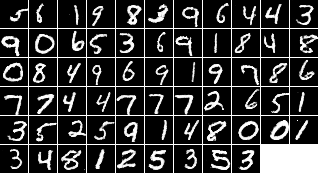

Target mask:


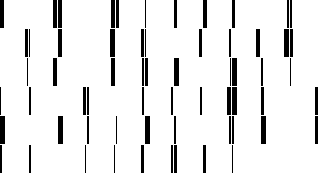

[   71980 Epoch:[ 0/100] [ 180/1093] time: 32.2886, d_loss: 0.75929326, g_loss: 3.08397746, walk_loss: 3.08397651
TEST: Inside Target image:


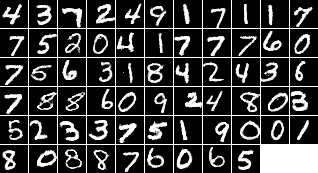

Target mask:


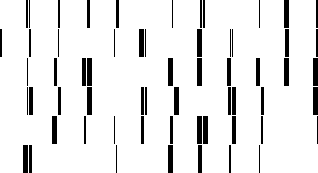

[   71981 Epoch:[ 0/100] [ 181/1093] time: 32.4168, d_loss: 0.87650883, g_loss: 2.97218299, walk_loss: 2.97218299
TEST: Inside Target image:


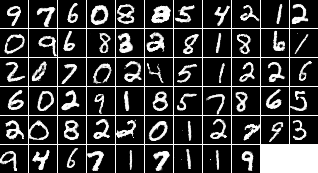

Target mask:


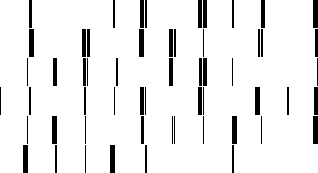

[   71982 Epoch:[ 0/100] [ 182/1093] time: 32.5424, d_loss: 0.79492402, g_loss: 3.10585833, walk_loss: 3.10585833
TEST: Inside Target image:


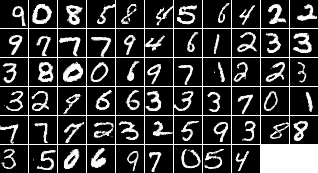

Target mask:


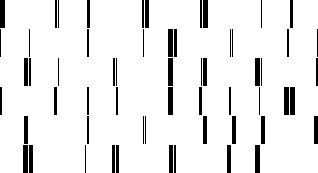

[   71983 Epoch:[ 0/100] [ 183/1093] time: 32.6602, d_loss: 0.85362774, g_loss: 2.91734314, walk_loss: 2.91734266
TEST: Inside Target image:


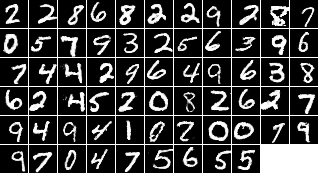

Target mask:


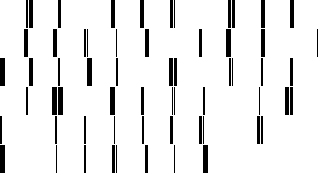

[   71984 Epoch:[ 0/100] [ 184/1093] time: 32.7881, d_loss: 0.80375040, g_loss: 3.12517786, walk_loss: 3.12517762
TEST: Inside Target image:


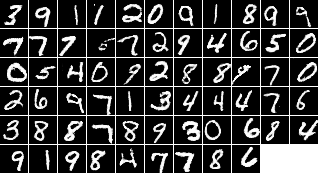

Target mask:


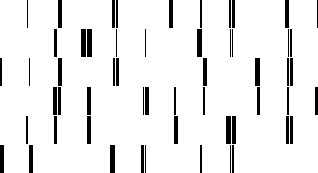

[   71985 Epoch:[ 0/100] [ 185/1093] time: 32.8776, d_loss: 0.71896017, g_loss: 3.35451508, walk_loss: 3.35451508
TEST: Inside Target image:


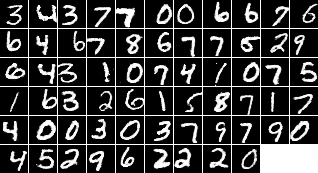

Target mask:


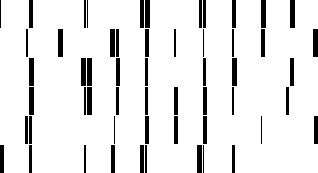

[   71986 Epoch:[ 0/100] [ 186/1093] time: 32.9863, d_loss: 0.83583707, g_loss: 3.08639956, walk_loss: 3.08639979
TEST: Inside Target image:


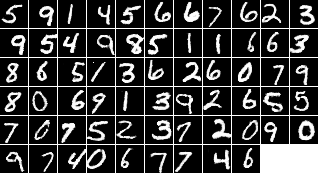

Target mask:


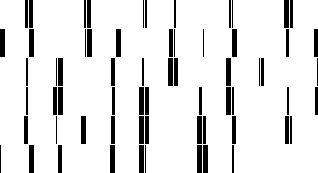

[   71987 Epoch:[ 0/100] [ 187/1093] time: 33.1125, d_loss: 0.93200755, g_loss: 3.14438486, walk_loss: 3.14438486
TEST: Inside Target image:


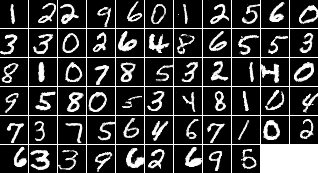

Target mask:


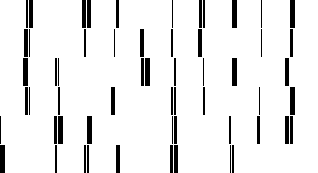

[   71988 Epoch:[ 0/100] [ 188/1093] time: 33.2318, d_loss: 0.90534759, g_loss: 3.01535368, walk_loss: 3.01535416
TEST: Inside Target image:


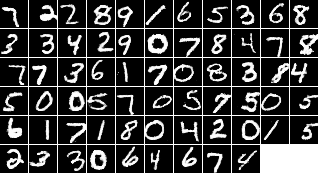

Target mask:


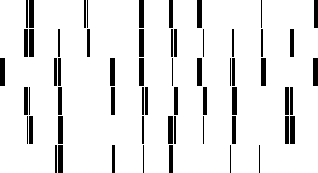

[   71989 Epoch:[ 0/100] [ 189/1093] time: 33.3506, d_loss: 0.93360066, g_loss: 3.23079205, walk_loss: 3.23079228
TEST: Inside Target image:


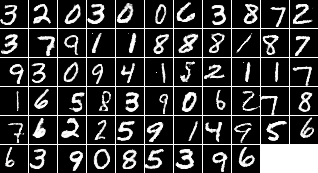

Target mask:


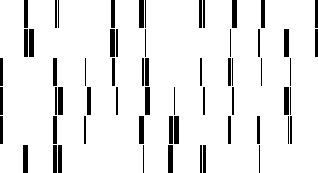

[   71990 Epoch:[ 0/100] [ 190/1093] time: 33.4717, d_loss: 0.86457902, g_loss: 2.90069294, walk_loss: 2.90069294
TEST: Inside Target image:


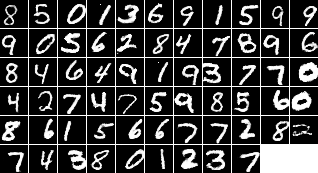

Target mask:


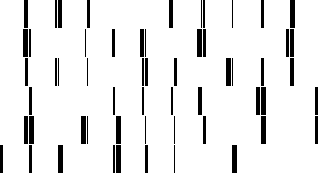

[   71991 Epoch:[ 0/100] [ 191/1093] time: 33.5951, d_loss: 0.82617033, g_loss: 3.04129577, walk_loss: 3.04129577
TEST: Inside Target image:


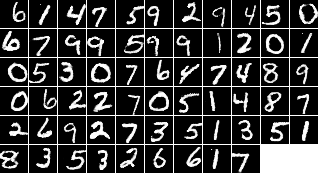

Target mask:


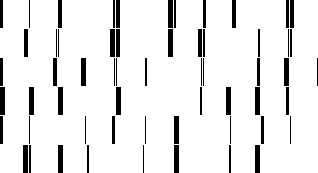

[   71992 Epoch:[ 0/100] [ 192/1093] time: 33.7141, d_loss: 0.84076077, g_loss: 2.90562677, walk_loss: 2.90562630
TEST: Inside Target image:


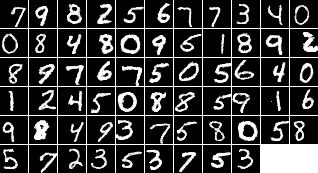

Target mask:


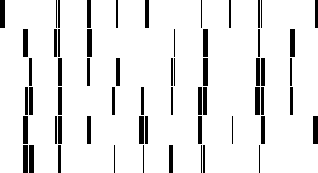

[   71993 Epoch:[ 0/100] [ 193/1093] time: 33.8351, d_loss: 0.84946322, g_loss: 2.99421287, walk_loss: 2.99421263
TEST: Inside Target image:


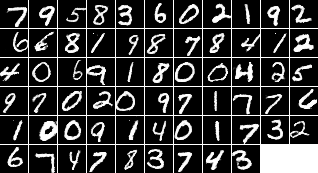

Target mask:


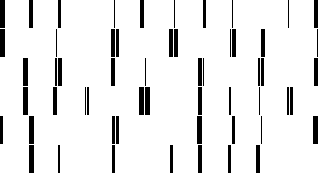

[   71994 Epoch:[ 0/100] [ 194/1093] time: 33.9561, d_loss: 0.78371060, g_loss: 3.22434902, walk_loss: 3.22434902
TEST: Inside Target image:


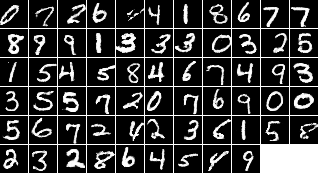

Target mask:


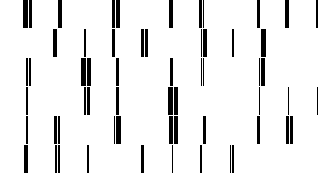

[   71995 Epoch:[ 0/100] [ 195/1093] time: 34.0752, d_loss: 0.91134036, g_loss: 3.15139771, walk_loss: 3.15139771
TEST: Inside Target image:


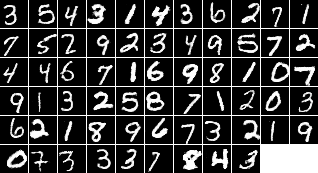

Target mask:


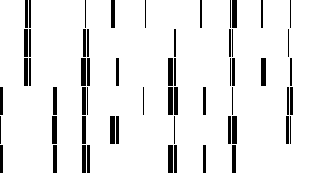

[   71996 Epoch:[ 0/100] [ 196/1093] time: 34.1983, d_loss: 0.83253652, g_loss: 3.21323276, walk_loss: 3.21323299
TEST: Inside Target image:


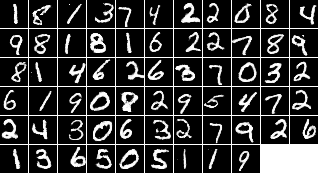

Target mask:


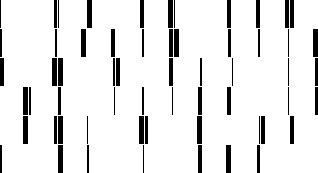

[   71997 Epoch:[ 0/100] [ 197/1093] time: 34.3197, d_loss: 0.84320349, g_loss: 3.23038673, walk_loss: 3.23038673
TEST: Inside Target image:


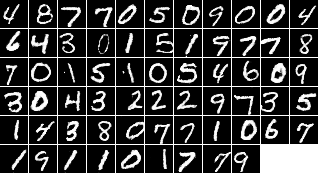

Target mask:


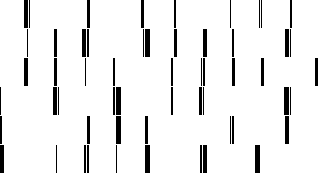

[   71998 Epoch:[ 0/100] [ 198/1093] time: 34.4385, d_loss: 0.87790328, g_loss: 3.24016452, walk_loss: 3.24016452
TEST: Inside Target image:


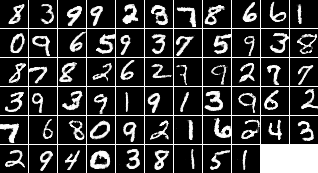

Target mask:


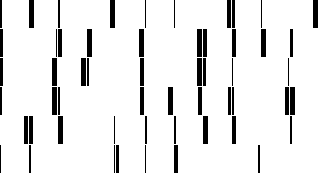

[   71999 Epoch:[ 0/100] [ 199/1093] time: 34.5577, d_loss: 0.76226914, g_loss: 3.10220051, walk_loss: 3.10220051
TEST: Inside Target image:


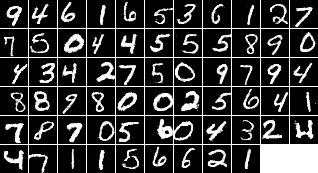

Target mask:


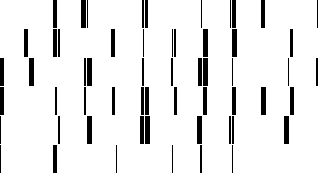

[   72000 Epoch:[ 0/100] [ 200/1093] time: 34.6856, d_loss: 0.75914615, g_loss: 3.18156028, walk_loss: 3.18156052
TEST: Inside Target image:


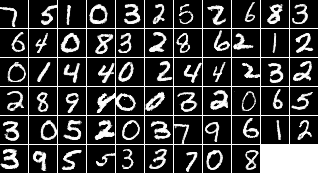

Target mask:


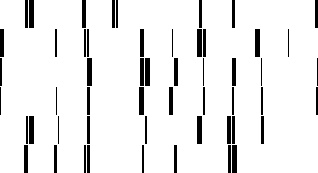

[Sample] d_loss: 1.2656283378601074, g_loss: 4.098574638366699, w_loss: 4.098574638366699
TEST: Inside Target image:


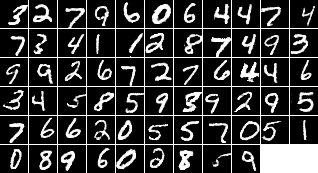

Target mask:


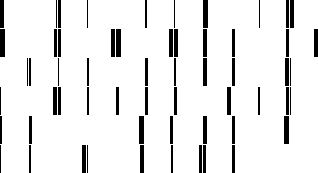

[   72001 Epoch:[ 0/100] [ 201/1093] time: 39.1467, d_loss: 0.84723443, g_loss: 3.10481215, walk_loss: 3.10481119
TEST: Inside Target image:


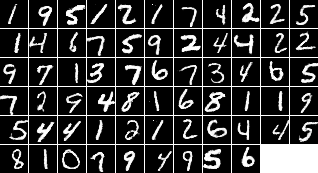

Target mask:


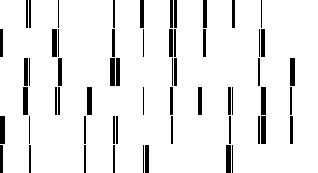

[   72002 Epoch:[ 0/100] [ 202/1093] time: 39.2678, d_loss: 0.84108776, g_loss: 2.99274969, walk_loss: 2.99274921
TEST: Inside Target image:


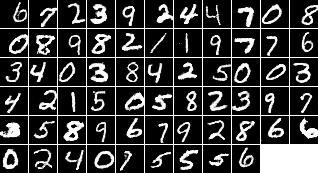

Target mask:


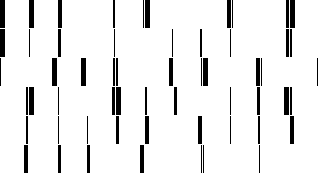

[   72003 Epoch:[ 0/100] [ 203/1093] time: 39.3935, d_loss: 0.87976223, g_loss: 3.17825842, walk_loss: 3.17825842
TEST: Inside Target image:


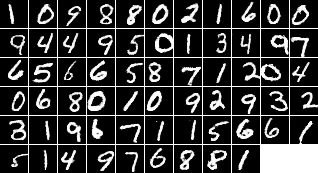

Target mask:


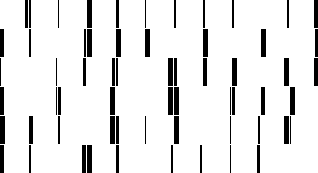

[   72004 Epoch:[ 0/100] [ 204/1093] time: 39.5124, d_loss: 0.76219118, g_loss: 3.33972120, walk_loss: 3.33972096
TEST: Inside Target image:


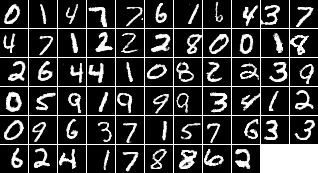

Target mask:


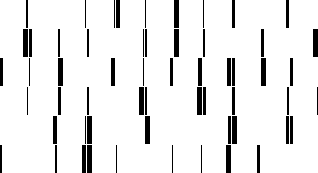

[   72005 Epoch:[ 0/100] [ 205/1093] time: 39.6034, d_loss: 0.83713520, g_loss: 2.99609923, walk_loss: 2.99609852
TEST: Inside Target image:


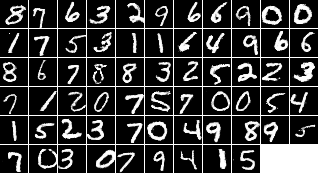

Target mask:


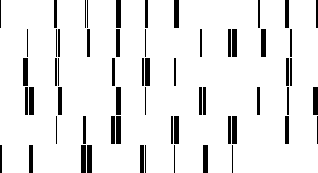

[   72006 Epoch:[ 0/100] [ 206/1093] time: 39.7050, d_loss: 0.78181791, g_loss: 3.07399130, walk_loss: 3.07399082
TEST: Inside Target image:


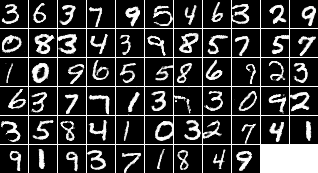

Target mask:


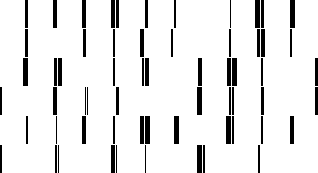

[   72007 Epoch:[ 0/100] [ 207/1093] time: 39.8285, d_loss: 0.84807026, g_loss: 3.00361085, walk_loss: 3.00361109
TEST: Inside Target image:


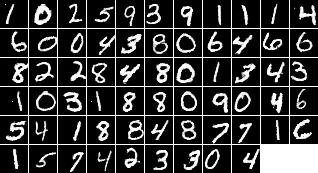

Target mask:


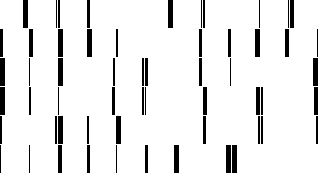

[   72008 Epoch:[ 0/100] [ 208/1093] time: 39.9543, d_loss: 0.78855431, g_loss: 3.21926308, walk_loss: 3.21926236
TEST: Inside Target image:


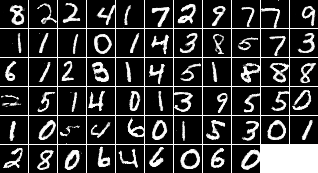

Target mask:


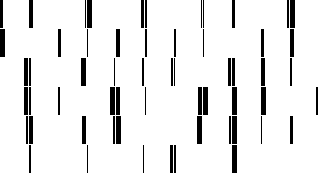

[   72009 Epoch:[ 0/100] [ 209/1093] time: 40.0752, d_loss: 0.83233535, g_loss: 3.00900269, walk_loss: 3.00900245
TEST: Inside Target image:


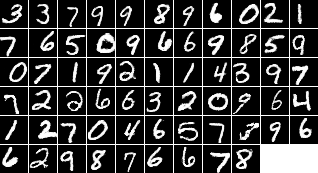

Target mask:


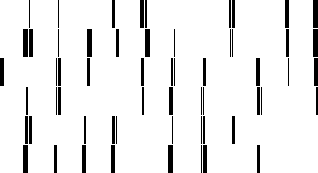

[   72010 Epoch:[ 0/100] [ 210/1093] time: 40.1941, d_loss: 0.87364531, g_loss: 3.03807926, walk_loss: 3.03807950
TEST: Inside Target image:


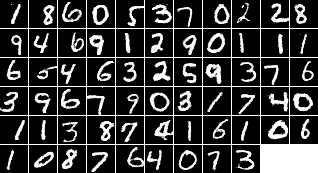

Target mask:


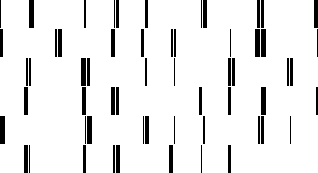

[   72011 Epoch:[ 0/100] [ 211/1093] time: 40.3129, d_loss: 0.84461194, g_loss: 3.04362559, walk_loss: 3.04362631
TEST: Inside Target image:


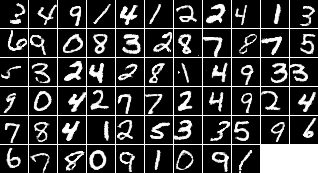

Target mask:


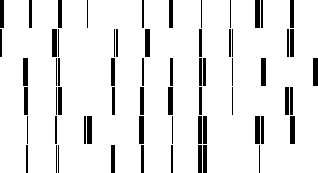

[   72012 Epoch:[ 0/100] [ 212/1093] time: 40.4271, d_loss: 0.81523955, g_loss: 2.97323298, walk_loss: 2.97323298
TEST: Inside Target image:


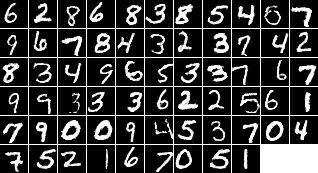

Target mask:


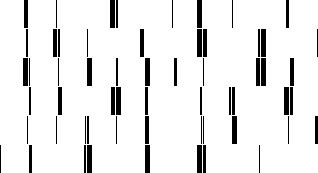

[   72013 Epoch:[ 0/100] [ 213/1093] time: 40.5503, d_loss: 0.92565382, g_loss: 2.96103501, walk_loss: 2.96103477
TEST: Inside Target image:


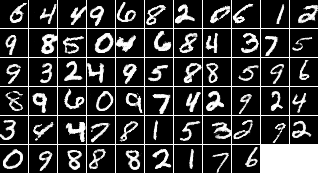

Target mask:


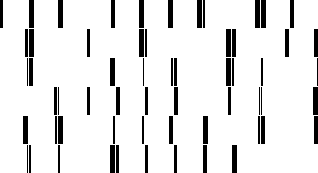

[   72014 Epoch:[ 0/100] [ 214/1093] time: 40.6739, d_loss: 0.86493182, g_loss: 3.10968065, walk_loss: 3.10968018
TEST: Inside Target image:


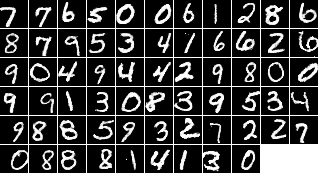

Target mask:


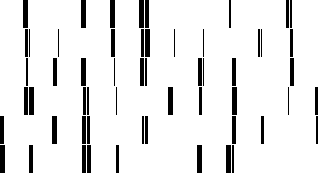

[   72015 Epoch:[ 0/100] [ 215/1093] time: 40.7925, d_loss: 0.87467915, g_loss: 3.10388851, walk_loss: 3.10388899
TEST: Inside Target image:


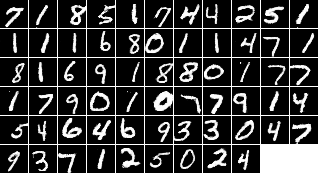

Target mask:


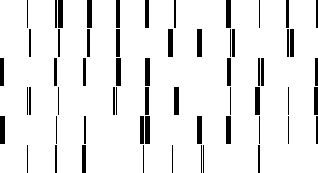

[   72016 Epoch:[ 0/100] [ 216/1093] time: 40.9133, d_loss: 0.83521509, g_loss: 3.03800082, walk_loss: 3.03800106
TEST: Inside Target image:


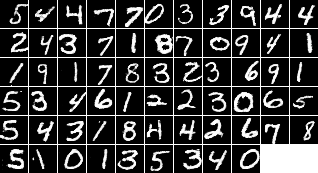

Target mask:


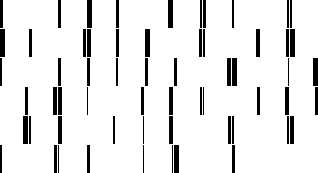

[   72017 Epoch:[ 0/100] [ 217/1093] time: 41.0372, d_loss: 0.88444436, g_loss: 3.11339593, walk_loss: 3.11339617
TEST: Inside Target image:


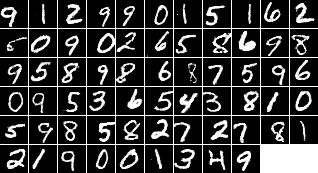

Target mask:


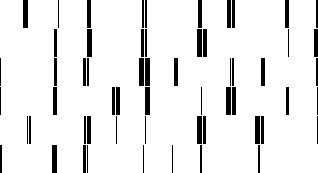

[   72018 Epoch:[ 0/100] [ 218/1093] time: 41.1629, d_loss: 0.76737213, g_loss: 2.98934054, walk_loss: 2.98934150
TEST: Inside Target image:


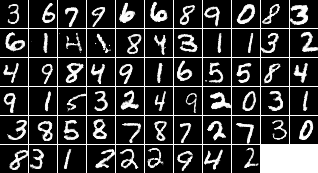

Target mask:


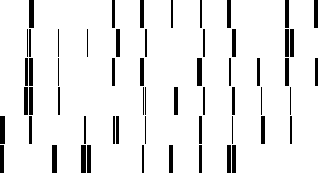

[   72019 Epoch:[ 0/100] [ 219/1093] time: 41.2883, d_loss: 0.85741025, g_loss: 3.02039361, walk_loss: 3.02039337
TEST: Inside Target image:


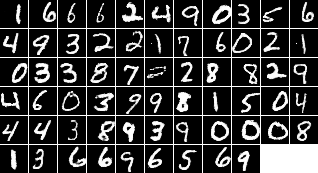

Target mask:


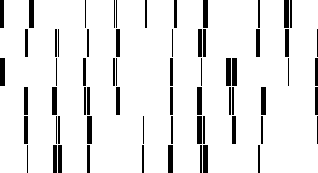

[   72020 Epoch:[ 0/100] [ 220/1093] time: 41.4139, d_loss: 0.80103230, g_loss: 3.00863957, walk_loss: 3.00863934
TEST: Inside Target image:


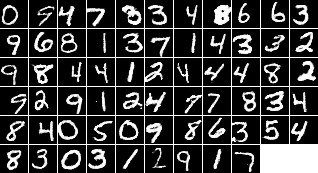

Target mask:


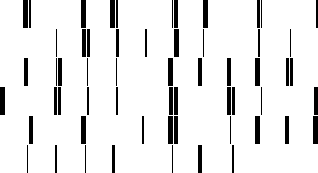

[   72021 Epoch:[ 0/100] [ 221/1093] time: 41.5378, d_loss: 0.93969464, g_loss: 2.95879030, walk_loss: 2.95879054
TEST: Inside Target image:


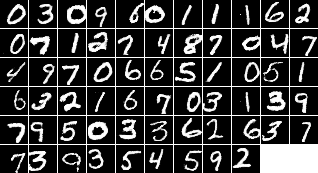

Target mask:


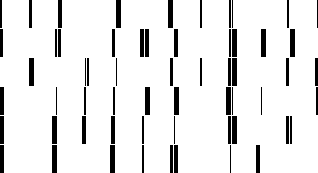

[   72022 Epoch:[ 0/100] [ 222/1093] time: 41.6423, d_loss: 0.92672324, g_loss: 2.94163442, walk_loss: 2.94163465
TEST: Inside Target image:


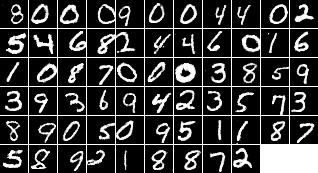

Target mask:


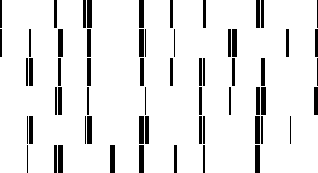

[   72023 Epoch:[ 0/100] [ 223/1093] time: 41.7399, d_loss: 0.91215658, g_loss: 2.84863281, walk_loss: 2.84863329
TEST: Inside Target image:


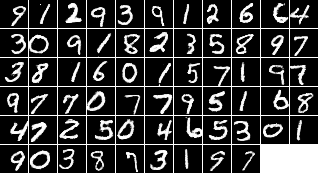

Target mask:


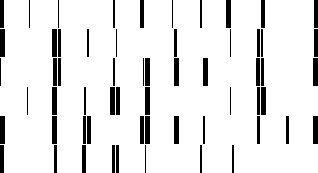

[   72024 Epoch:[ 0/100] [ 224/1093] time: 41.8539, d_loss: 0.81801784, g_loss: 2.93347454, walk_loss: 2.93347478
TEST: Inside Target image:


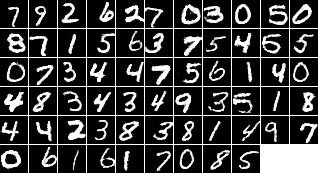

Target mask:


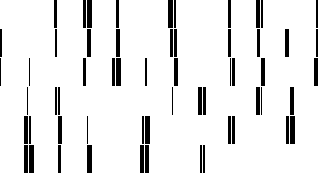

[   72025 Epoch:[ 0/100] [ 225/1093] time: 41.9734, d_loss: 0.95807517, g_loss: 2.93735981, walk_loss: 2.93736029
TEST: Inside Target image:


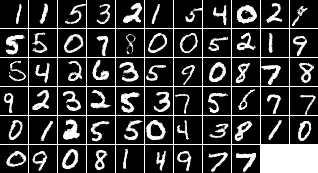

Target mask:


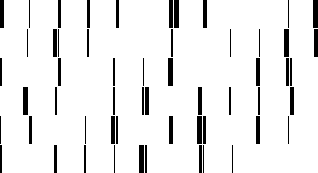

[   72026 Epoch:[ 0/100] [ 226/1093] time: 42.0949, d_loss: 0.83650649, g_loss: 3.16160154, walk_loss: 3.16160202
TEST: Inside Target image:


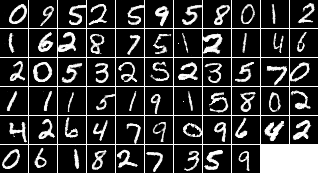

Target mask:


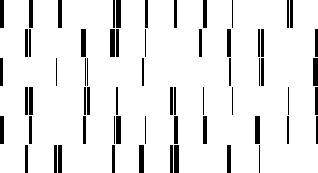

[   72027 Epoch:[ 0/100] [ 227/1093] time: 42.2136, d_loss: 0.89826578, g_loss: 3.08130884, walk_loss: 3.08130836
TEST: Inside Target image:


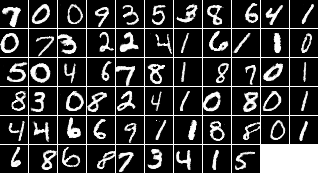

Target mask:


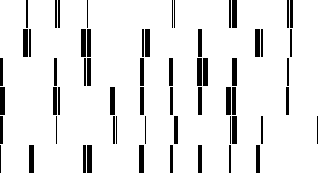

[   72028 Epoch:[ 0/100] [ 228/1093] time: 42.3372, d_loss: 0.75892502, g_loss: 3.17902923, walk_loss: 3.17902923
TEST: Inside Target image:


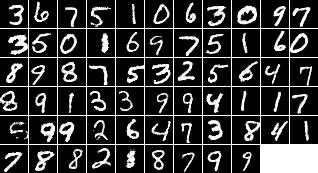

Target mask:


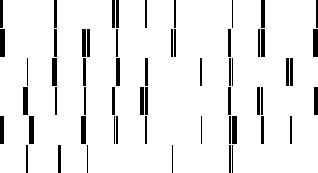

[   72029 Epoch:[ 0/100] [ 229/1093] time: 42.4629, d_loss: 0.90931863, g_loss: 3.04886675, walk_loss: 3.04886627
TEST: Inside Target image:


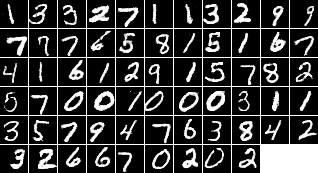

Target mask:


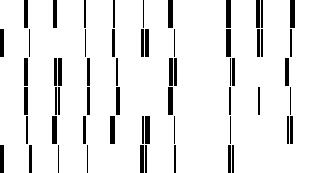

[   72030 Epoch:[ 0/100] [ 230/1093] time: 42.5840, d_loss: 0.81735194, g_loss: 2.91890430, walk_loss: 2.91890383
TEST: Inside Target image:


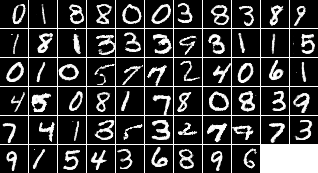

Target mask:


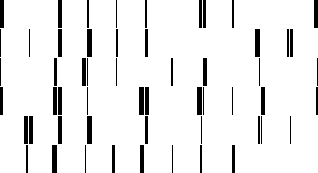

[   72031 Epoch:[ 0/100] [ 231/1093] time: 42.7031, d_loss: 0.88305628, g_loss: 2.94734716, walk_loss: 2.94734740
TEST: Inside Target image:


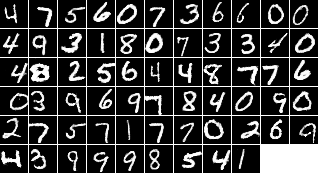

Target mask:


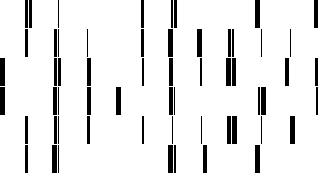

[   72032 Epoch:[ 0/100] [ 232/1093] time: 42.8223, d_loss: 0.87284744, g_loss: 3.02486897, walk_loss: 3.02486825
TEST: Inside Target image:


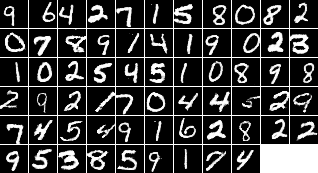

Target mask:


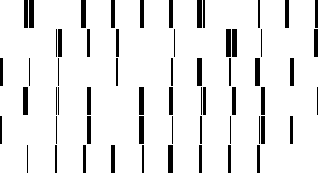

[   72033 Epoch:[ 0/100] [ 233/1093] time: 42.9456, d_loss: 0.77780825, g_loss: 3.09777188, walk_loss: 3.09777260
TEST: Inside Target image:


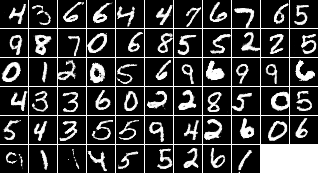

Target mask:


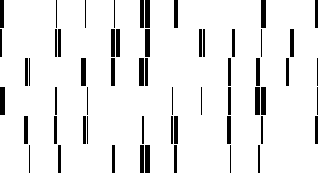

[   72034 Epoch:[ 0/100] [ 234/1093] time: 43.0601, d_loss: 0.85237885, g_loss: 3.08179593, walk_loss: 3.08179641
TEST: Inside Target image:


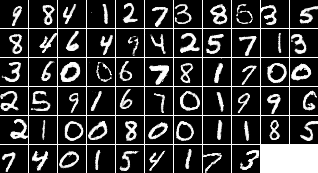

Target mask:


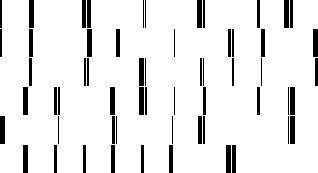

[   72035 Epoch:[ 0/100] [ 235/1093] time: 43.1814, d_loss: 0.88537902, g_loss: 3.12890220, walk_loss: 3.12890220
TEST: Inside Target image:


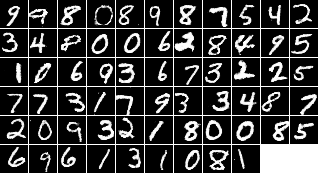

Target mask:


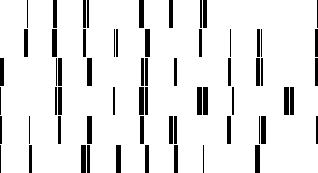

KeyboardInterrupt: 

In [3]:
# tf.app.run(argv=['--transform_type', 'shiftx', '--dataset', 'mnist', '--train', '--input_height=28', '--output_height=28', '--train'])
## I changed the default for mnist so shorter version is:
tf.app.run(argv=['', '--transform_type', 'shiftx', '--steer', '--alpha_max=14'])